In [1]:
import plumed
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import MDAnalysis as md
from MDAnalysis.analysis import distances
import pandas as pd
import itertools
import random
import deeptime
from deeptime.decomposition import TICA
from deeptime.covariance import KoopmanWeightingEstimator
from deeptime.clustering import MiniBatchKMeans
from deeptime.markov import TransitionCountEstimator
from deeptime.markov.msm import MaximumLikelihoodMSM
from deeptime.markov.msm import BayesianMSM
from deeptime.plots import plot_implied_timescales
from deeptime.util.validation import implied_timescales
from deeptime.plots.chapman_kolmogorov import plot_ck_test
import networkx as nx
from copy import deepcopy
import torch
from torch import nn, optim, autograd
from torch.nn import functional as F
from torch.utils.data.dataset import random_split
from snrv import Snrv, load_snrv
import math
import string

import warnings
warnings.filterwarnings('ignore')

import os
os.environ['PATH'] = '/usr/local/Climber:/usr/local/pymol:/usr/local/gromacs/bin:/usr/local/plumed/bin:/usr/local/openmpi/bin:/usr/local/cuda-12.2/bin:/usr/local/clash:/home/mingyuan/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/snap/bin'
os.environ['LD_LIBRARY_PATH'] = '/usr/local/gromacs/lib:/usr/local/plumed/lib:/usr/local/libtorch/lib:/usr/local/openmpi/lib:/usr/local/cuda-12.2/lib64:'
os.environ['CPATH'] = '/usr/local/libtorch/include/torch:/usr/local/libtorch/include/:/usr/local/libtorch/include/torch/csrc/api/include/:'
os.environ['INCLUDE'] = '/usr/local/libtorch/include/torch:/usr/local/libtorch/include/:/usr/local/libtorch/include/torch/csrc/api/include/:'

In [2]:
# USE THIS TO CLEAR CUDA MEMORY
import gc
torch.cuda.empty_cache()
gc.collect()

20

In [3]:
!plumed

Nothing to do. Use 'plumed help' for help


In [4]:
print(torch.__version__)

2.2.2+cu121


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

#### 0. Useful Functions

In [6]:
# RCflow
class GaussianPrior(nn.Module):
    def __init__(self, mean_value, std_value):
        super().__init__()
        self.mean_ = nn.Parameter(torch.tensor(mean_value, dtype=torch.float32), requires_grad=False)
        self.std_ = nn.Parameter(torch.tensor(std_value, dtype=torch.float32), requires_grad=False)

    def forward(self, size):
        samples = self.mean_ + self.std_ * torch.randn(size).to(self.mean_.device)
        return samples

    def sample_like(self, x):
        size = x.size()
        samples = self.forward(size).to(x.device)
        return samples


class RCFlow(nn.Module):
    def __init__(self,input_size,latent_size,encoder_hidden_size,encode_state_label,hidden_size,hidden_depth,activation,sigma,
                 learning_rate,lr_decay,lr_decay_stepsize,val_frac,batch_size,batchnorm,n_epochs,device):
        super().__init__()
        
        # Neural network related
        self.input_size = input_size               # No. of features
        self.latent_size = latent_size
        self.encoder_hidden_size = encoder_hidden_size
        self.hidden_size = hidden_size
        self.hidden_depth = hidden_depth
        self.activation = activation
        self.batchnorm = batchnorm
        self.encode_state_label = encode_state_label
        self.sigma = sigma                         # the gaussian width of flow matching vector field sample, 
                                                   # serves as a regularization factor

        # Training related
        self.learning_rate = learning_rate
        self.lr_decay = lr_decay
        self.lr_decay_stepsize = lr_decay_stepsize
        self.val_frac = val_frac
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.device = device

        # Cached attributes
        self.encoder = None
        self.L_vector_field = None
        self.D_vector_field = None
        self.optimizer = None
        self.scheduler = None
        self.train_loss = None
        self.validation_loss = None
        
        #####
        
        ### Encoder x --> r(x) as a feed forward nn
        self.encoder = []
        # first layer
        self.encoder.append(nn.Linear(self.input_size,self.encoder_hidden_size))
        # Insert dropout/batchnorm here
        # Activation
        self.encoder.append(self.activation)
        if self.batchnorm == True:
            self.encoder.append(nn.BatchNorm1d(self.encoder_hidden_size))
        # middle layers
        for i in range(self.hidden_depth-1):
            self.encoder.append(nn.Linear(self.encoder_hidden_size,self.encoder_hidden_size))
            self.encoder.append(self.activation)
            if self.batchnorm == True:
                self.encoder.append(nn.BatchNorm1d(self.encoder_hidden_size))
        
        # final output layer
        self.encoder.append(nn.Linear(self.encoder_hidden_size,self.latent_size))
        
        if self.encode_state_label == True:
            self.encoder.append(nn.Softmax())
            
        self.encoder = nn.Sequential(*self.encoder).to(self.device)

        #####

        ### nn that represents the lumpability vector field u(r(x),y,t)
        self.L_vector_field = []
        L_input_size = self.latent_size + self.input_size + 1
        
        # first layer
        self.L_vector_field.append(nn.Linear(L_input_size,self.hidden_size))
        self.L_vector_field.append(self.activation)
        if self.batchnorm == True:
            self.L_vector_field.append(nn.BatchNorm1d(self.hidden_size))
        # middle layers
        for i in range(self.hidden_depth-1):
            self.L_vector_field.append(nn.Linear(self.hidden_size,self.hidden_size))
            self.L_vector_field.append(self.activation)
            if self.batchnorm == True:
                self.L_vector_field.append(nn.BatchNorm1d(self.hidden_size))
        # final output layer
        self.L_vector_field.append(nn.Linear(self.hidden_size,self.input_size))
        self.L_vector_field = nn.Sequential(*self.L_vector_field).to(self.device)

        #####
        
        ### nn that represents the decomposibility vector field u(r(y),x,t)
        self.D_vector_field = []
        
        D_input_size = self.latent_size + self.input_size + 1
        
        # first layer
        self.D_vector_field.append(nn.Linear(D_input_size,self.hidden_size))
        self.D_vector_field.append(self.activation)
        if self.batchnorm == True:
            self.D_vector_field.append(nn.BatchNorm1d(self.hidden_size))
        # middle layers
        for i in range(self.hidden_depth-1):
            self.D_vector_field.append(nn.Linear(self.hidden_size,self.hidden_size))
            self.D_vector_field.append(self.activation)
            if self.batchnorm == True:
                self.D_vector_field.append(nn.BatchNorm1d(self.hidden_size))
        # final output layer
        self.D_vector_field.append(nn.Linear(self.hidden_size,self.input_size))
        self.D_vector_field = nn.Sequential(*self.D_vector_field).to(self.device)

        #####
        
    def encode(self,x):
        # Here, x is the variable to be encoded i.e. for lumpability x:= x for decomposibility x:= y
        # encode x --> r:=r(x)
        r = self.encoder(x)
        return r

    def sample_from_prior(self,x):
        # Sample x/y (D_loss/L_loss) from prior, prior_sample should have shape (batch_size,input_size)
        # Since this is just a gaussian with mean & s.t.d from all data, x/y can share the same prior
        prior_sample = self.prior.sample_like(x)
        return prior_sample

    def sample_t(self,x):
        # Sample t = [t_1,...t_B], t should have shape (batch_size,)
        t = torch.rand_like(x[:,:1])
        return t

    def sample_x_t(self,x,t,prior_sample): 
        # Sample x_t/y_t, the 'location' of x/y after 'time' t in the vector field
        x_t = x * t + (1-t) * prior_sample + torch.randn_like(x) * self.sigma
        return x_t

    def data_vector_field(self,x_t,prior_sample):
        # Calculate v_t, the 'data vector field' that we want to match our 'neural network vector field' with
        v_t = x_t - prior_sample
        return v_t

    def L_loss(self,x,y,t,rx=None):
        # Step 1: encode x --> r(x)
        if rx == None:
            rx = self.encode(x)
        
        # Step 2: sample y from prior
        prior_y = self.sample_from_prior(y)
        
        # Step 3: sample y_t, y at time t in the vector field
        y_t = self.sample_x_t(y,t,prior_y)
        
        # Step 4: compute 'data vector field'
        v_t = self.data_vector_field(y_t,prior_y)
        
        # Step 5: compute 'nn vector field'
        u_input = torch.cat((rx,y_t,t),dim=-1)
        # so that u_t is a function of rx,y_t,t only i.e. rx contains nearly same information as x
        u_t = self.L_vector_field(u_input)
        
        # Step 6: compute flow matching loss
        L_loss = torch.mean(torch.sum((u_t-v_t)**2,-1))
        
        return L_loss
    
    def D_loss(self,x,y,t,ry=None):
        # Step 1: encode y --> r(y)
        if ry == None:
            ry = self.encode(y)
        
        # Step 2: sample x from prior
        prior_x = self.sample_from_prior(x)
        
        # Step 3: sample x_t, x at time t in the vector field
        x_t = self.sample_x_t(x,t,prior_x)
        
        # Step 4: compute 'data vector field'
        v_t = self.data_vector_field(x_t,prior_x)
        
        # Step 5: compute 'nn vector field'
        u_input = torch.cat((ry,x_t,t),dim=-1)
        # so that u_t is a function of rx,y_t,t only i.e. rx contains nearly same information as x
        u_t = self.L_vector_field(u_input)
        
        # Step 6: compute flow matching loss
        D_loss = torch.mean(torch.sum((u_t-v_t)**2,-1))
        
        return D_loss

    def fit(self,data,lagtime):
        # NB: usually we use tica_output as data
        # Initialize the gaussian prior
        prior_mean = np.mean(np.concatenate(data),axis=0)
        prior_sigma = np.std(np.concatenate(data),axis=0)
        self.prior = GaussianPrior(prior_mean,prior_sigma).to(self.device)

        # Create time-lagged dataset: this outputs a 3d numpy array with shape (no_frame,2,no_features)
        # the second dimension represents the time-lagged pairs X_t,X_t+tau
        dataset = create_timelagged_dataset(data,lagtime)
        
        # Create training set and validation set
        n_pairs = len(dataset)
        train_size = int((1-self.val_frac)*n_pairs)
        val_size = n_pairs - train_size
        train_data, val_data = random_split(dataset,[train_size,val_size])
        train_loader = torch.utils.data.DataLoader(train_data, batch_size = self.batch_size,shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_data, batch_size = self.batch_size)  
        
        # Training
        self.optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=self.lr_decay_stepsize, gamma=self.lr_decay)
        
        train_loss = []
        validation_loss = []
        
        with torch.autograd.set_detect_anomaly(True):
            for epoch in range(1, n_epochs + 1):
                train_loss_epoch = []
                validation_loss_epoch = []
                
                # Training
                for minibatch_data in train_loader:
                    # Prepare x and y, should both in shape (batchsize,no_features)
                    x = minibatch_data[:,0,:].to(self.device)
                    y = minibatch_data[:,1,:].to(self.device)
                    # Sample t
                    t = self.sample_t(x)
                    # Compute losses
                    L_loss = self.L_loss(x,y,t)
                    D_loss = self.D_loss(x,y,t)
                    loss = L_loss + D_loss
                    # back propagation
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
                    # Record current minibatch loss
                    train_loss_epoch.append(loss.item())
                train_loss_epoch = np.mean(train_loss_epoch)
                train_loss.append(train_loss_epoch)
                
                # learning rate decay
                self.scheduler.step()

                # Validation
                with torch.no_grad():
                    for minibatch_data in val_loader:
                        # Prepare x and y, should both in shape (batchsize,no_features)
                        x = minibatch_data[:,0,:].to(self.device)
                        y = minibatch_data[:,1,:].to(self.device)
                        # Sample t
                        t = self.sample_t(x)
                        # Compute losses
                        L_loss = self.L_loss(x,y,t)
                        D_loss = self.D_loss(x,y,t)
                        loss = L_loss + D_loss
                        # Record current minibatch loss
                        validation_loss_epoch.append(loss.item())
                    validation_loss_epoch = np.mean(validation_loss_epoch)
                    validation_loss.append(validation_loss_epoch)

                print('Epoch {}: Train loss = {:.4f}, Validation loss = {:.4f}'.format(epoch,train_loss_epoch,validation_loss_epoch))

        self.train_loss = train_loss
        self.validation_loss = validation_loss
                
        return None
        
    def transform(self,data_concat):
        r = self.encode(torch.tensor(data_concat,dtype=torch.float32).to(self.device)).cpu().detach().numpy()
        return r

    def save_model(self,filepath):
        torch.save(self,filepath)
        return None
        
    def plot_loss(self,sim_idx):
        fig,ax = plt.subplots()
        ax.plot(self.train_loss,label='train')
        ax.plot(self.validation_loss,label='validation')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        plt.legend()
        plt.savefig('figures/round{sim_idx}_rcflow_loss.png'.format(sim_idx=sim_idx-1),dpi=600)

# We want to organize time-series trajectories of TICA eigenvectors into time-lagged pairs according to lagtime
# i.e. tica_output + tica_output_supp --> data in RCflow, should be inshape (no_time_lagged_pairs, no_features * 2)
def create_timelagged_dataset(tica_output,lagtime):
    timelagged_dataset = []
    tica_data = list(tica_output)
    for tica_data_i in tica_data:
        for i in range(tica_data_i.shape[0]-lagtime):
            lagged_pair_i = np.vstack([tica_data_i[i],tica_data_i[i+lagtime]])
            lagged_pair_i = np.array(lagged_pair_i)
            timelagged_dataset.append(lagged_pair_i)
    timelagged_dataset = torch.tensor(np.array(timelagged_dataset),dtype=torch.float32)
    return timelagged_dataset

def minmax_normalization(data,axis=0):
    data_max = data.max(axis=0)
    data_min = data.min(axis=0)
    normalized_data = (data - data_min) / (data_max - data_min)
    return normalized_data

In [7]:
# TICA and MSM related functions

def run_TICA(data,lagtime,dim=None,var_cutoff=None,koopman=True):
    tica = TICA(lagtime=lagtime,dim=dim,var_cutoff=var_cutoff)
    if koopman == True:
        koopman_estimator = KoopmanWeightingEstimator(lagtime=lagtime)
        reweighting_model = koopman_estimator.fit(data).fetch_model()
        tica = tica.fit(data, weights=reweighting_model).fetch_model()
    else:
        tica = tica.fit(data).fetch_model()
    # tica is the data-fitted model, which contains eigenvalues and eigenvectors
    # tica_output is the tranformed time-series data in TICA space in shape(traj_idx,no_frames,dim)
    # tica_output_concat is tica_output in shape(traj_idx*no_frames,dim)
    tica_output = tica.transform(data)
        
    return tica,tica_output

def run_kmeans(tica_output,n_microstates,n_jobs):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=n_microstates,batch_size=10000,max_iter=100,init_strategy='kmeans++',n_jobs=n_jobs)
    microstates = minibatch_kmeans.fit(tica_output).fetch_model()
    cluster_centers = microstates.cluster_centers
    assignments = microstates.transform(tica_output)
    return assignments,cluster_centers

def evaluate_its(lagtimes,assignments,n_its):
    models = []
    for lagtime in lagtimes:
        counts = TransitionCountEstimator(lagtime=lagtime, count_mode='sliding').fit_fetch(assignments)
        models.append(MaximumLikelihoodMSM().fit_fetch(counts))
    its_data = implied_timescales(models)
    fig, ax = plt.subplots(1, 1)
    plot_implied_timescales(its_data, n_its=n_its, ax=ax)
    ax.set_yscale('log')
    ax.set_title('Implied timescales')
    ax.set_xlabel('lag time (steps)')
    ax.set_ylabel('timescale (steps)')
    #plt.savefig('its.png',dpi=600)
    return None

def build_MSM(msm_lagtime,assignments):
    counts = TransitionCountEstimator(lagtime=msm_lagtime, count_mode='sliding').fit_fetch(assignments)
    msm = MaximumLikelihoodMSM().fit_fetch(counts)
    return msm

#### 1. Global parameters

In [107]:
#### Some global parameters

# Increase latent size to compare
rcflow_lagtime = 10
latent_size = 2

# TICA
dim = 30
var_cutoff = None
koopman = False

#### Number of models trained
no_models = 10

#### Minibatch k-means
n_microstates = 200
n_jobs = 32
#### ITS
n_its = 2
its_lagtimes = [1,2,5,10,20,30,40,50,75,100,125,150,175,200,250,300,350,400]
ns_per_step = 0.2                              # Convert steps into ns

#### msm and cktest
msm_lagtime = 200
converged_its = 1000
n_space = 9
ck_lagtimes = np.linspace(msm_lagtime,converged_its,n_space,dtype=int)

# 2D FES
temperature = 340

# PCCA
n_metastable_sets = 3

stride = 10
markersize = 3

batchsize_transform = 1024

#### 2. Eigenvalues comparison
In preliminary tests we found that a TICA with dim=30 retains the most dynamical information at lagtime=10. We now first perform a standard 30-dim TICA+MSM for ITS analysis to determine how many slow modes and metastable states that we would like to analyze.

In [9]:
### Read data

# In principle, we do not need to include any e^-d functions, 
# since they are all functions of interatomic distances
data = plumed.read_as_pandas('CV/COLVAR')
data = data.drop(columns=['time'])
columns = list(data.columns.values)
for column in columns:
    if column[:3] == 'phi' or column[:3] == 'psi' or column[:3] == 'chi' or column[:5] == 'omega':
        data = data.drop(columns=[column])
data = [data.to_numpy()]
data[0].shape

(534743, 277)

In [10]:
# Read TICA data, where e^-d (d is the selected interatomic distances) are introduced as extra in the basis set.

# Traj timestep = 0.2ns
data_tica = plumed.read_as_pandas('CV/COLVAR_tica')
data_tica = data_tica.drop(columns=['time'])
columns = list(data_tica.columns.values)
for column in columns:
    if column[:3] == 'phi' or column[:3] == 'psi' or column[:3] == 'chi' or column[:5] == 'omega':
        data_tica = data_tica.drop(columns=[column])
data_tica = data_tica.to_numpy()
print(data_tica.shape)

(534743, 484)


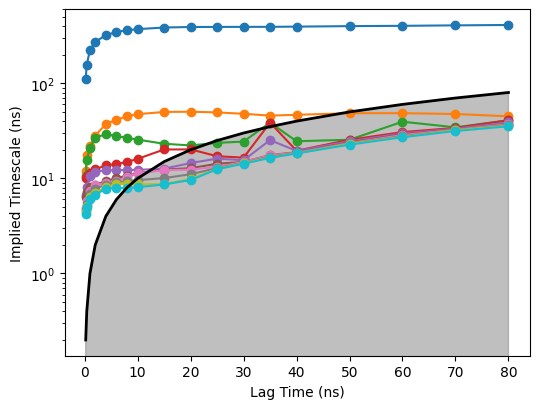

In [12]:
tica,tica_output = run_TICA(data_tica,rcflow_lagtime,dim,var_cutoff,koopman)
assignments,cluster_centers = run_kmeans(tica_output,n_microstates=n_microstates,n_jobs=n_jobs)

n_its = 10

# ITS
models = []
for its_lagtime in its_lagtimes:
    counts = TransitionCountEstimator(lagtime=its_lagtime, count_mode='sliding').fit_fetch(assignments)
    models.append(MaximumLikelihoodMSM().fit_fetch(counts))
its_data_i = implied_timescales(models)
fig, ax = plt.subplots(figsize=(6,4.5))
for i in range(n_its):
    ax.plot(its_data_i.lagtimes * ns_per_step, its_data_i.timescales_for_process(i) * ns_per_step, marker='o')
ax.plot(its_data_i.lagtimes * ns_per_step, its_data_i.lagtimes * ns_per_step, linewidth=2, color='black')
ax.fill_between(its_data_i.lagtimes * ns_per_step, np.full((its_data_i.n_lagtimes,), fill_value=ax.get_ylim()[0]), its_data_i.lagtimes * ns_per_step,
                alpha=0.5, color='grey')
ax.set_yscale('log')
ax.set_xlabel('Lag Time (ns)')
ax.set_ylabel('Implied Timescale (ns)')
plt.savefig('figures/ITS/reference_tica_dim30_ITS.png',dpi=600)
plt.show()

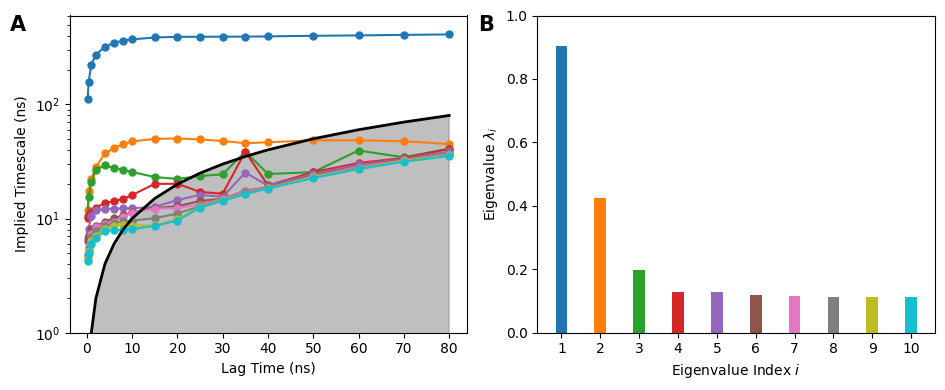

In [13]:
n_its = 10

index_x = -0.15
index_y = 0.95

# build an MSM using lagtime = 200
msm = build_MSM(msm_lagtime,assignments)

# Plot eigenvalues and merge with ITS
eigenvalues_idx = np.linspace(1,n_its,n_its)

fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(9.5,4))

for i in range(n_its):
    ax[0].plot(its_data_i.lagtimes * ns_per_step, its_data_i.timescales_for_process(i) * ns_per_step, marker='o',ms=5)
ax[0].plot(its_data_i.lagtimes * ns_per_step, its_data_i.lagtimes * ns_per_step, linewidth=2, color='black')
ax[0].fill_between(its_data_i.lagtimes * ns_per_step, np.full((its_data_i.n_lagtimes,), fill_value=ax[0].get_ylim()[0]), its_data_i.lagtimes * ns_per_step,
                alpha=0.5, color='grey')
ax[0].set_yscale('log')
ax[0].set_ylim(1,ax[0].get_ylim()[1])
ax[0].set_xlabel('Lag Time (ns)')
ax[0].set_ylabel('Implied Timescale (ns)')

for i in range(n_its):
    ax[1].bar(eigenvalues_idx[i],np.abs(msm.eigenvalues()[1:11])[i],width=0.3)
ax[1].set_xticks(eigenvalues_idx)
ax[1].set_ylim(0,1)
ax[1].set_xlabel('Eigenvalue Index $i$')
ax[1].set_ylabel('Eigenvalue $\lambda_i$')

ax[0].text(index_x, index_y, string.ascii_uppercase[0],transform=ax[0].transAxes, size=15, weight='bold')
ax[1].text(index_x, index_y, string.ascii_uppercase[1],transform=ax[1].transAxes, size=15, weight='bold')

plt.tight_layout()
plt.savefig('figures/reference_tica_dim30_ITS_eigenvalues.png',dpi=600)
plt.show()

In [ ]:
dims = [30,20,10,6,2]
eigenvalues_tica_dint = []

var_cutoff = None
dim = None
tica,tica_output = run_TICA(data[0],rcflow_lagtime,dim,var_cutoff,koopman)
assignments,cluster_centers = run_kmeans(tica_output,n_microstates=n_microstates,n_jobs=n_jobs)
msm = build_MSM(msm_lagtime,assignments)
eigenvalues_tica_dint.append(msm.eigenvalues()[1:3])

var_cutoff = 0.95
dim = None
tica,tica_output = run_TICA(data[0],rcflow_lagtime,dim,var_cutoff,koopman)
assignments,cluster_centers = run_kmeans(tica_output,n_microstates=n_microstates,n_jobs=n_jobs)
msm = build_MSM(msm_lagtime,assignments)
eigenvalues_tica_dint.append(msm.eigenvalues()[1:3])

var_cutoff = None
for dim in dims:
    tica,tica_output = run_TICA(data[0],rcflow_lagtime,dim,var_cutoff,koopman)
    assignments,cluster_centers = run_kmeans(tica_output,n_microstates=n_microstates,n_jobs=n_jobs)
    msm = build_MSM(msm_lagtime,assignments)
    eigenvalues_tica_dint.append(msm.eigenvalues()[1:3])

##### 2.1 Eigenvalue comparison between TICA (dim=30,10,6,2), SRV, SPIB and RCFlow at lagtime=40ns
We require the output RC dimensions of all neural network based algorithms to be 2, for easier visualization and enhanced sampling purposes. Additionally, we improve TICA by introducing extra non-linear basis functions into the basis set.

In [11]:
# Initialize lists for storage
eigenvalues_tica_mean = []
eigenvalues_tica_std = []

In [12]:
dims = [30,2]
no_models = 10
for dim in dims:
    tica,tica_output = run_TICA(data_tica,rcflow_lagtime,dim,var_cutoff,koopman)
    eigenvalues_tica_dim = []
    for i in range(no_models):
        assignments,cluster_centers = run_kmeans(tica_output,n_microstates=n_microstates,n_jobs=n_jobs)
        msm = build_MSM(msm_lagtime,assignments)
        eigenvalues_tica_dim.append(msm.eigenvalues()[1:3])
    eigenvalues_tica_dim = np.array(eigenvalues_tica_dim)
    eigenvalues_tica_mean_dim = np.mean(eigenvalues_tica_dim,axis=0)
    eigenvalues_tica_std_dim = np.std(eigenvalues_tica_dim,axis=0)
    eigenvalues_tica_mean.append(eigenvalues_tica_mean_dim)
    eigenvalues_tica_std.append(eigenvalues_tica_std_dim)

In [13]:
### RCFlow
dim = 30
tica,tica_output = run_TICA(data,rcflow_lagtime,dim,var_cutoff,koopman)
tica_output_concat = np.concatenate(tica_output)

eigenvalues_rcflow = []

for i in range(no_models):
    rcflow = torch.load('models/rcflow-lag10-sincos-256hidden-{i}-dim=30.pt'.format(i=i))
    
    # Transform into RC space
    no_iteration = tica_output_concat.shape[0]//batchsize_transform + 1
        
    r = []
    for k in range(no_iteration):
        r_k = rcflow.transform(tica_output_concat[k*batchsize_transform:(k+1)*batchsize_transform])
        r.append(r_k)
    r = np.concatenate(r)
        
    # Normalize r for better clustering result
    normalized_r = minmax_normalization(r,axis=0)
        
    # kmeans
    assignments,cluster_centers = run_kmeans(normalized_r,n_microstates=n_microstates,n_jobs=n_jobs)

    msm = build_MSM(msm_lagtime,assignments)
    eigenvalues_rcflow.append(msm.eigenvalues()[1:3])

In [14]:
### SPIB
# Using TICA dim=30 + kmeans clustering as input
batch_size = 4096

traj_data = data[0]
eigenvalues_state = []
eigenvalues_kmeans = []

for idx in range(no_models):
    IB = torch.load('SPIB/spib_d=2_t=10_b=0.0010_learn=0.000030_final_SPIB{idx}_ticadim30.model'.format(idx=idx))
    labels, prediction, z_latent, _ = IB.transform(traj_data, batch_size=batch_size, to_numpy=True)
    # Calculate ITS and eigenvalues for MSM from SPIB output state labels
    assignments = labels
    msm = build_MSM(msm_lagtime,assignments)
    eigenvalues_state.append(msm.eigenvalues()[1:3])
    
    # Calculate ITS and eigenvalues for MSM from clustering in SPIB latent space
    normalized_z = minmax_normalization(z_latent,axis=0)
    assignments,cluster_centers = run_kmeans(normalized_z,n_microstates=n_microstates,n_jobs=n_jobs)
    msm = build_MSM(msm_lagtime,assignments)
    eigenvalues_kmeans.append(msm.eigenvalues()[1:3])

In [15]:
# SRV
dataset = torch.tensor(data[0],dtype=torch.float32)
eigenvalues_srv = []

for i in range(no_models):
    srv = load_snrv('models/srv-lag10-sincos-100hidden-final-100epoch-{i}.pt'.format(i=i))
    srv_output = []

    no_iteration = dataset.shape[0]//batchsize_transform + 1
    srv_output = []
    for i in range(no_iteration):
        srv_output_i = srv.transform(dataset[i*batchsize_transform:(i+1)*batchsize_transform]).cpu().detach().numpy()
        srv_output.append(srv_output_i)
    srv_output = np.concatenate(srv_output)
    assignments,cluster_centers = run_kmeans(srv_output[:,1:],n_microstates,n_jobs)
    msm = build_MSM(msm_lagtime,assignments)
    eigenvalues_srv.append(msm.eigenvalues()[1:n_its+1])

In [16]:
# The effect of lag time on RCFlow eigenvalues
rcflow_lagtimes = [1,5,25,50,100]
eigenvalues_rcflow_lag_mean = []
eigenvalues_rcflow_lag_std = []

for rcflow_lagtime_i in rcflow_lagtimes:
    eigenvalues_rcflow_lag_i = []
    tica,tica_output = run_TICA(data,rcflow_lagtime_i,dim,var_cutoff,koopman)
    tica_output_concat = np.concatenate(tica_output)
    for j in range(no_models):
        rcflow_ij = torch.load('models/rcflow-lag{rcflow_lagtime_i}-sincos-256hidden-{j}-dim=30.pt'.format(rcflow_lagtime_i=rcflow_lagtime_i,j=j))
        # Transform into RC space
        no_iteration = tica_output_concat.shape[0]//batchsize_transform + 1
            
        r = []
        for k in range(no_iteration):
            r_k = rcflow_ij.transform(tica_output_concat[k*batchsize_transform:(k+1)*batchsize_transform])
            r.append(r_k)
        r = np.concatenate(r)
            
        # Normalize r for better clustering result
        normalized_r = minmax_normalization(r,axis=0)
            
        # kmeans
        assignments,cluster_centers = run_kmeans(normalized_r,n_microstates=n_microstates,n_jobs=n_jobs)
    
        msm = build_MSM(msm_lagtime,assignments)
        eigenvalues_rcflow_lag_i.append(msm.eigenvalues()[1:n_its+1])
    eigenvalues_rcflow_lag_mean.append(np.array(eigenvalues_rcflow_lag_i).mean(axis=0))
    eigenvalues_rcflow_lag_std.append(np.array(eigenvalues_rcflow_lag_i).std(axis=0))

In [17]:
eigenvalues_mean = []
eigenvalues_std = []

eigenvalues_mean += eigenvalues_tica_mean 
eigenvalues_std += eigenvalues_tica_std

eigenvalues_mean.append(np.mean(eigenvalues_rcflow,axis=0))
eigenvalues_std.append(np.std(eigenvalues_rcflow,axis=0))

eigenvalues_mean.append(np.mean(eigenvalues_state,axis=0))
eigenvalues_std.append(np.std(eigenvalues_state,axis=0))

eigenvalues_mean.append(np.mean(eigenvalues_kmeans,axis=0))
eigenvalues_std.append(np.std(eigenvalues_kmeans,axis=0))

eigenvalues_mean.append(np.mean(eigenvalues_srv,axis=0))
eigenvalues_std.append(np.std(eigenvalues_srv,axis=0))

eigenvalues_mean += eigenvalues_rcflow_lag_mean
eigenvalues_std += eigenvalues_rcflow_lag_std

In [18]:
eigenvalues_rcflow  # best 2, worst 1

[array([0.90508636, 0.46295441]),
 array([0.905141  , 0.41694232]),
 array([0.90510603, 0.47212736]),
 array([0.90519615, 0.46808672]),
 array([0.90504048, 0.46782316]),
 array([0.90510693, 0.46657334]),
 array([0.90511948, 0.4638463 ]),
 array([0.90508225, 0.4520163 ]),
 array([0.90513974, 0.47300029]),
 array([0.9050989 , 0.44824188])]

In [19]:
eigenvalues_kmeans # best 1, worst 3

[array([0.90215437, 0.21825768]),
 array([0.90306128, 0.42984355]),
 array([0.90185704, 0.13041034]),
 array([0.90196375, 0.08369776]),
 array([0.90218816, 0.09792083]),
 array([0.90308864, 0.40181696]),
 array([0.90254691, 0.42656243]),
 array([0.90331119, 0.42375518]),
 array([0.90269686, 0.24199185]),
 array([0.90253734, 0.37673465])]

In [20]:
np.array(eigenvalues_srv)[:,:2] # best 1, worst 4

array([[0.90346519, 0.21956625],
       [0.90377769, 0.40104194],
       [0.90352745, 0.22276629],
       [0.90348049, 0.31548085],
       [0.90331023, 0.17965833],
       [0.90348866, 0.22284645],
       [0.90359037, 0.23741118],
       [0.90359324, 0.19325199],
       [0.90360137, 0.21240905],
       [0.90364628, 0.25272118]])

In [21]:
eigenvalues_mean,eigenvalues_std

([array([0.90373252, 0.43310167]),
  array([0.90261063, 0.11658801]),
  array([0.90511173, 0.45916121]),
  array([0.89850911, 0.19472069]),
  array([0.90254055, 0.28309912]),
  array([0.9035481 , 0.24571535]),
  array([0.90385626, 0.33911378]),
  array([0.90486979, 0.44866141]),
  array([0.90546783, 0.45244265]),
  array([0.90647617, 0.45436067]),
  array([0.90671312, 0.44441209])],
 [array([0.00027526, 0.00308193]),
  array([5.36808157e-05, 8.87067683e-03]),
  array([3.95435475e-05, 1.59947804e-02]),
  array([0.00145654, 0.1498795 ]),
  array([0.00047572, 0.13712086]),
  array([0.00011874, 0.06250622]),
  array([0.00028146, 0.11459406]),
  array([0.00018392, 0.01522816]),
  array([0.00014461, 0.00415427]),
  array([0.00014709, 0.00420782]),
  array([0.00014788, 0.0044102 ])])

##### 2.2 Plotting Eigenvalues

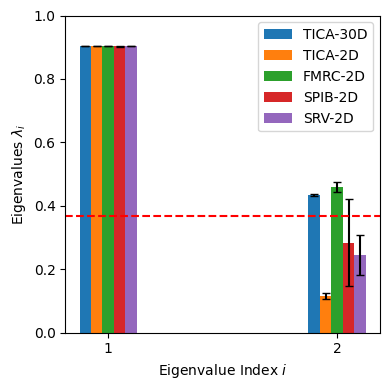

In [23]:
# Figure: An overall comparison
# Compare eigenvalues with TICA-based clustering
label = ['TICA-30D','TICA-2D','FMRC-2D','SPIB-2D','SRV-2D']
idx_eig = [0,1,2,4,5]

fig,ax = plt.subplots(figsize=(4,4))
width = 0.05
n_eigenvalues = 2

x_ticks = np.linspace(1,n_eigenvalues,n_eigenvalues)
x = x_ticks - len(label)/2 * width + 0.5* width

for n,i in enumerate(idx_eig):
    plt.bar(x,eigenvalues_mean[i][:n_eigenvalues],yerr=eigenvalues_std[i][:n_eigenvalues],label=label[n],width=width,capsize=3)
    x = x + width

cutoff = 0.369
plt.axhline(cutoff,linestyle='dashed',color='red')
plt.xticks(x_ticks)
plt.xlabel('Eigenvalue Index $i$')
plt.ylabel('Eigenvalues $\lambda_i$')
plt.ylim(0,1)
plt.legend()
plt.tight_layout()
plt.savefig('figures/eigenvalues_compare.png',dpi=600)
plt.show()

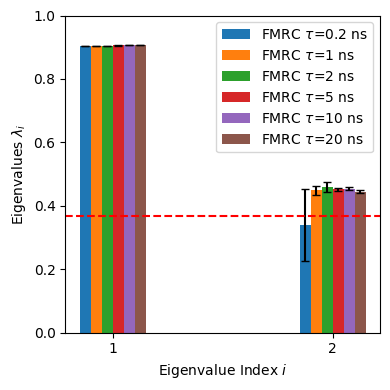

In [25]:
# Figure: Effect of lagtime
label = [r'FMRC $\tau$=0.2 ns',r'FMRC $\tau$=1 ns',r'FMRC $\tau$=2 ns',r'FMRC $\tau$=5 ns',r'FMRC $\tau$=10 ns',r'FMRC $\tau$=20 ns']
idx_eig = [6,7,2,8,9,10]

fig,ax = plt.subplots(figsize=(4,4))
width = 0.05
n_eigenvalues = 2

x_ticks = np.linspace(1,n_eigenvalues,n_eigenvalues)
x = x_ticks - len(label)/2 * width + 0.5* width

for n,i in enumerate(idx_eig):
    plt.bar(x,eigenvalues_mean[i][:n_eigenvalues],yerr=eigenvalues_std[i][:n_eigenvalues],label=label[n],width=width,capsize=3)
    x = x + width

cutoff = 0.369
plt.axhline(cutoff,linestyle='dashed',color='red')
plt.xticks(x_ticks)
plt.xlabel('Eigenvalue Index $i$')
plt.ylabel('Eigenvalues $\lambda_i$')
plt.ylim(0,1)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('figures/eigenvalues_lagtime_compare.png',dpi=600)
plt.show()

In [26]:
# Save for future reference
np.save('eigenvalues_mean.npy',eigenvalues_mean)
np.save('eigenvalues_std.npy',eigenvalues_std)

#### 3. Implied Timescale Comparison
Here, we select the best and worst performing model from each algorithm according to the VAMP score and then compare their ITS convergence. 

Best RCFlow index: 2     SPIB index: 1        SRV index: 1

Worst RCFlow index: 1    SPIB index: 3        SRV index: 4

In [27]:
its_data_best = []

# TICA 30D
dim = 30
var_cutoff = None
koopman = False

tica,tica_output = run_TICA(data_tica,rcflow_lagtime,dim,var_cutoff,koopman)
assignments,cluster_centers = run_kmeans(tica_output,n_microstates=n_microstates,n_jobs=n_jobs)
models = []
for its_lagtime in its_lagtimes:
    counts = TransitionCountEstimator(lagtime=its_lagtime, count_mode='sliding').fit_fetch(assignments)
    models.append(MaximumLikelihoodMSM().fit_fetch(counts))
its_data_i = implied_timescales(models)
its_data_best.append(its_data_i)

# RCFlow
tica,tica_output = run_TICA(data,rcflow_lagtime,dim,var_cutoff,koopman)
tica_output_concat = np.concatenate(tica_output)

rcflow = torch.load('models/rcflow-lag10-sincos-256hidden-2-dim=30.pt')

# Transform into RC space
no_iteration = tica_output_concat.shape[0]//batchsize_transform + 1
    
r = []
for k in range(no_iteration):
    r_k = rcflow.transform(tica_output_concat[k*batchsize_transform:(k+1)*batchsize_transform])
    r.append(r_k)
r = np.concatenate(r)

# Normalize r for better clustering result
normalized_r = minmax_normalization(r,axis=0)
assignments,cluster_centers = run_kmeans(normalized_r,n_microstates=n_microstates,n_jobs=n_jobs)
    
models = []
for its_lagtime in its_lagtimes:
    counts = TransitionCountEstimator(lagtime=its_lagtime, count_mode='sliding').fit_fetch(assignments)
    models.append(MaximumLikelihoodMSM().fit_fetch(counts))
its_data_i = implied_timescales(models)
its_data_best.append(its_data_i)

# SPIB
IB = torch.load('SPIB/spib_d=2_t=10_b=0.0010_learn=0.000030_final_SPIB1_ticadim30.model')
labels, prediction, z_latent, _ = IB.transform(traj_data, batch_size=batch_size, to_numpy=True)

### In general, we found that clustering in normalized latent space with a large n_microstates 
### is better than using the output state labels

# Calculate ITS and eigenvalues for MSM from SPIB output state labels
# assignments = labels
# Calculate ITS and eigenvalues for MSM from clustering in SPIB latent space
normalized_z = minmax_normalization(z_latent,axis=0)
assignments,cluster_centers = run_kmeans(normalized_z,n_microstates=n_microstates,n_jobs=n_jobs)

models = []
for its_lagtime in its_lagtimes:
    counts = TransitionCountEstimator(lagtime=its_lagtime, count_mode='sliding').fit_fetch(assignments)
    models.append(MaximumLikelihoodMSM().fit_fetch(counts))
its_data_i = implied_timescales(models)
its_data_best.append(its_data_i)

# SRV
srv = load_snrv('models/srv-lag10-sincos-100hidden-final-100epoch-1.pt')

# Transform into RC space
no_iteration = traj_data.shape[0]//batchsize_transform + 1

# Transforming the whole dataset at once might exceed CUDA memory capacity.
# We can transform a small amount of samples every transformation and then concats all transformed data, similar to minibatch training

srv_output = []
for i in range(no_iteration):
    srv_output_i = srv.transform(dataset[i*batchsize_transform:(i+1)*batchsize_transform]).cpu().detach().numpy()
    srv_output.append(srv_output_i)
srv_output = np.concatenate(srv_output)

# kmeans
assignments,cluster_centers = run_kmeans(srv_output[:,1:],n_microstates=n_microstates,n_jobs=n_jobs)

models = []
for its_lagtime in its_lagtimes:
    counts = TransitionCountEstimator(lagtime=its_lagtime, count_mode='sliding').fit_fetch(assignments)
    models.append(MaximumLikelihoodMSM().fit_fetch(counts))
its_data_i = implied_timescales(models)
its_data_best.append(its_data_i)

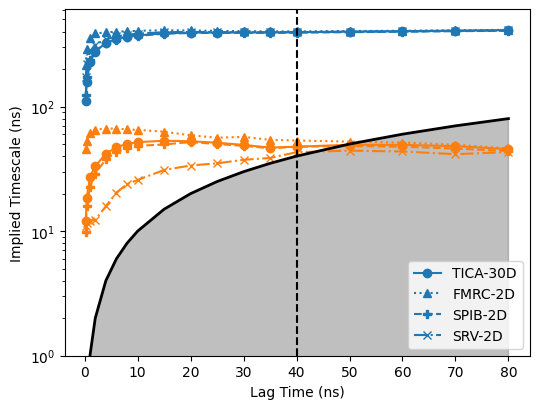

In [29]:
# Plot ITS:best
n_its = 2

labels = ['TICA-30D','FMRC-2D','SPIB-2D','SRV-2D']
linestyles = ['solid','dotted','dashed','dashdot']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:n_its]
markers = ['o','^','P','x']

fig, ax = plt.subplots(figsize=(6,4.5))
for j in range(len(labels)):
    for i in range(n_its):
        if i == 0:
            ax.plot(its_data_best[j].lagtimes * ns_per_step, its_data_best[j].timescales_for_process(i) * ns_per_step, color=colors[i],label=labels[j],marker=markers[j],linestyle=linestyles[j],markersize=6)
        else:
            ax.plot(its_data_best[j].lagtimes * ns_per_step, its_data_best[j].timescales_for_process(i) * ns_per_step, color=colors[i],marker=markers[j],linestyle=linestyles[j],markersize=6)
ax.plot(its_data_i.lagtimes * ns_per_step, its_data_i.lagtimes * ns_per_step, linewidth=2, color='black')
ax.fill_between(its_data_i.lagtimes * ns_per_step, np.full((its_data_i.n_lagtimes,), fill_value=ax.get_ylim()[0]), its_data_i.lagtimes * ns_per_step,
                alpha=0.5, color='grey')
ax.set_yscale('log')
ax.set_xlabel('Lag Time (ns)')
ax.set_ylabel('Implied Timescale (ns)')
ax.set_ylim(1,ax.get_ylim()[1])
ax.axvline(40,color='black',linestyle='dashed')
ax.legend()
plt.savefig('figures/ITS/ITS-comparison_best.png',dpi=600)
plt.show()

#### 4.RCFlow

##### 4.1 RCFlow lag=10 2D FES, ITS, cktest, PCCA macrostates & Transition Network 

In [104]:
rcflow = torch.load('models/rcflow-lag10-sincos-256hidden-1-dim=30.pt')

In [108]:
# TICA
tica,tica_output = run_TICA(data,rcflow_lagtime,dim,var_cutoff,koopman)
tica_output_concat = np.concatenate(tica_output)

# Transform into RC space
no_iteration = tica_output_concat.shape[0]//batchsize_transform + 1
    
r = []
for k in range(no_iteration):
    r_k = rcflow.transform(tica_output_concat[k*batchsize_transform:(k+1)*batchsize_transform])
    r.append(r_k)
r = np.concatenate(r)
    
# Normalize r for better clustering result
normalized_r = minmax_normalization(r,axis=0)
    
# kmeans
assignments,cluster_centers = run_kmeans(normalized_r,n_microstates=n_microstates,n_jobs=n_jobs)

In [109]:
# MSM
msm = build_MSM(msm_lagtime,assignments)

In [110]:
# Compute FES projected on 2D TICA space
unique_micro, count_micro = np.unique(assignments,return_counts=True)
assignments_weight = (msm.stationary_distribution / count_micro) / (msm.stationary_distribution / count_micro).sum()
assignments_weights = dict(enumerate(assignments_weight))
trajectory_weights = np.vectorize(assignments_weights.get)(assignments)

histogram_count, x_edge, y_edge = np.histogram2d(normalized_r[:,0],normalized_r[:,1],bins=(250,250),weights=trajectory_weights)
x_grid = 0.5 * (x_edge[:-1] + x_edge[1:])
y_grid = 0.5 * (y_edge[:-1] + y_edge[1:])

density = histogram_count / histogram_count.sum()
free_energy = -8.314*temperature/1000*np.log(density)
free_energy = free_energy-free_energy.min()

In [111]:
# PCCA
pcca = msm.pcca(n_metastable_sets=n_metastable_sets)

macro_assignments = dict(enumerate(pcca.assignments))
macro_timeseries = np.vectorize(macro_assignments.get)(assignments)

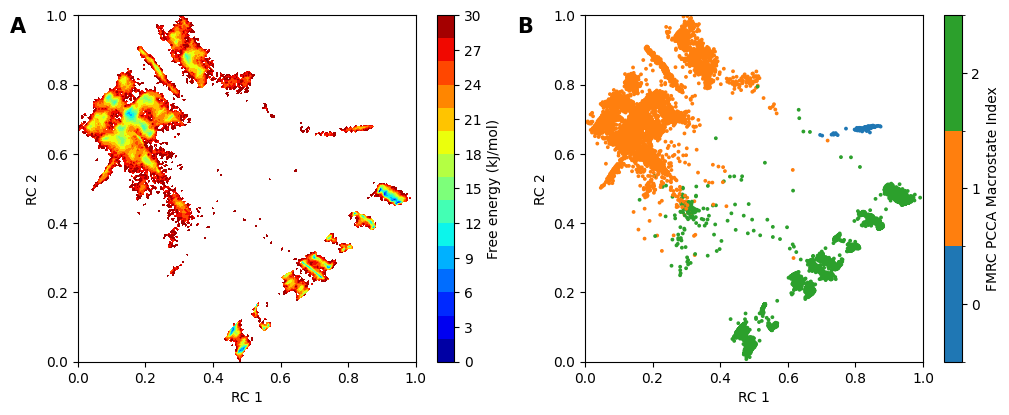

In [112]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(12,4.5))

index_x = -0.2
index_y = 0.95

# 2D FES contour plot
vmax = 30
levels = np.linspace(0,vmax,16)
ticks = np.linspace(0,vmax,11)
contourf = ax[0].contourf(x_grid,y_grid,free_energy.T,vmax=vmax,levels=levels,cmap='jet')
cb = fig.colorbar(contourf, ax=ax[0], label='Free energy (kJ/mol)',ticks=ticks)
ax[0].set_aspect('auto')
ax[0].set_xlabel('RC 1')
ax[0].set_ylabel('RC 2')
ax[0].set_xlim(0,1)
ax[0].set_ylim(0,1)

# PCCA assignments

cmap = matplotlib.colors.ListedColormap(plt.rcParams['axes.prop_cycle'].by_key()['color'][:n_metastable_sets])
norm = matplotlib.colors.BoundaryNorm(np.arange(-0.5,n_metastable_sets), cmap.N) 
sc = ax[1].scatter(normalized_r[:,0][::stride],normalized_r[:,1][::stride],c=macro_rcflow[::stride],cmap=cmap,norm=norm,s=markersize)
cb = fig.colorbar(sc,ticks=np.linspace(0,n_metastable_sets-1,n_metastable_sets),ax=ax[1],label='FMRC PCCA Macrostate Index')
ax[1].set_xlabel('RC 1')
ax[1].set_ylabel('RC 2')
ax[1].set_xlim(0,1)
ax[1].set_ylim(0,1)

ax[0].text(index_x, index_y, string.ascii_uppercase[0],transform=ax[0].transAxes, size=15, weight='bold')
ax[1].text(index_x, index_y, string.ascii_uppercase[1],transform=ax[1].transAxes, size=15, weight='bold')

plt.savefig('figures/fes_pcca/rcflow-lag10-fes_pcca-worst-1.png',dpi=600)
plt.show()

In [30]:
rcflow = torch.load('models/rcflow-lag10-sincos-256hidden-2-dim=30.pt')

In [31]:
rcflow_lagtime = 10

In [32]:
# TICA
dim = 30

tica,tica_output = run_TICA(data,rcflow_lagtime,dim,var_cutoff,koopman)
tica_output_concat = np.concatenate(tica_output)

# Transform into RC space
no_iteration = tica_output_concat.shape[0]//batchsize_transform + 1
    
r = []
for k in range(no_iteration):
    r_k = rcflow.transform(tica_output_concat[k*batchsize_transform:(k+1)*batchsize_transform])
    r.append(r_k)
r = np.concatenate(r)
    
# Normalize r for better clustering result
normalized_r = minmax_normalization(r,axis=0)
    
# kmeans
assignments,cluster_centers = run_kmeans(normalized_r,n_microstates=n_microstates,n_jobs=n_jobs)

In [33]:
# MSM
msm = build_MSM(msm_lagtime,assignments)

In [34]:
# Compute FES projected on 2D TICA space
unique_micro, count_micro = np.unique(assignments,return_counts=True)
assignments_weight = (msm.stationary_distribution / count_micro) / (msm.stationary_distribution / count_micro).sum()
assignments_weights = dict(enumerate(assignments_weight))
trajectory_weights = np.vectorize(assignments_weights.get)(assignments)

histogram_count, x_edge, y_edge = np.histogram2d(normalized_r[:,0],normalized_r[:,1],bins=(250,250),weights=trajectory_weights)
x_grid = 0.5 * (x_edge[:-1] + x_edge[1:])
y_grid = 0.5 * (y_edge[:-1] + y_edge[1:])

density = histogram_count / histogram_count.sum()
free_energy = -8.314*temperature/1000*np.log(density)
free_energy = free_energy-free_energy.min()

In [35]:
# PCCA
pcca = msm.pcca(n_metastable_sets=n_metastable_sets)

macro_assignments = dict(enumerate(pcca.assignments))
macro_timeseries = np.vectorize(macro_assignments.get)(assignments)

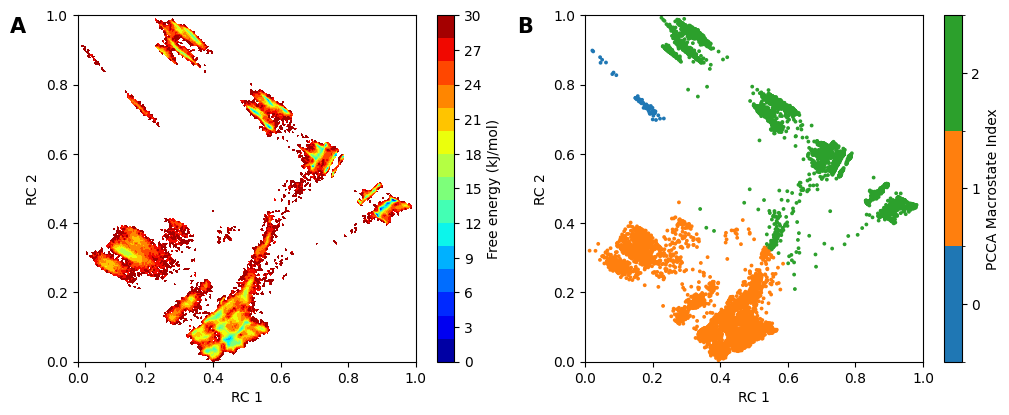

In [37]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(12,4.5))

index_x = -0.2
index_y = 0.95

# 2D FES contour plot
vmax = 30
levels = np.linspace(0,vmax,16)
ticks = np.linspace(0,vmax,11)
contourf = ax[0].contourf(x_grid,y_grid,free_energy.T,vmax=vmax,levels=levels,cmap='jet')
cb = fig.colorbar(contourf, ax=ax[0], label='Free energy (kJ/mol)',ticks=ticks)
ax[0].set_aspect('auto')
ax[0].set_xlabel('RC 1')
ax[0].set_ylabel('RC 2')
ax[0].set_xlim(0,1)
ax[0].set_ylim(0,1)

# PCCA assignments

cmap = matplotlib.colors.ListedColormap(plt.rcParams['axes.prop_cycle'].by_key()['color'][:n_metastable_sets])
norm = matplotlib.colors.BoundaryNorm(np.arange(-0.5,n_metastable_sets), cmap.N) 
sc = ax[1].scatter(normalized_r[:,0][::stride],normalized_r[:,1][::stride],c=macro_timeseries[::stride],cmap=cmap,norm=norm,s=markersize)
cb = fig.colorbar(sc,ticks=np.linspace(0,n_metastable_sets-1,n_metastable_sets),ax=ax[1],label='PCCA Macrostate Index')
ax[1].set_xlabel('RC 1')
ax[1].set_ylabel('RC 2')
ax[1].set_xlim(0,1)
ax[1].set_ylim(0,1)

ax[0].text(index_x, index_y, string.ascii_uppercase[0],transform=ax[0].transAxes, size=15, weight='bold')
ax[1].text(index_x, index_y, string.ascii_uppercase[1],transform=ax[1].transAxes, size=15, weight='bold')

#plt.savefig('figures/fes_pcca/rcflow-lag10-fes_pcca-best-2.png',dpi=600)
plt.show()

In [36]:
macro_rcflow = macro_timeseries     # Save best macrostate

In [149]:
# cktest
models = []
for ck_lagtime in ck_lagtimes:
    counts = TransitionCountEstimator(lagtime=ck_lagtime, count_mode='sliding').fit_fetch(assignments)
    models.append(MaximumLikelihoodMSM().fit_fetch(counts))
ck_test = msm.ck_test(models,n_metastable_sets=n_metastable_sets)

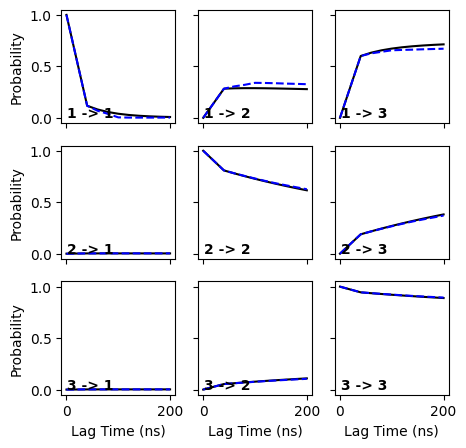

In [151]:
# cktest plot
fig,ax = plt.subplots(nrows=ck_test.n_components,ncols=ck_test.n_components,sharex=True,sharey=True,figsize=(5,5))
for i in range(ck_test.n_components):
    for j in range(ck_test.n_components):
        ax[i,j].plot(ck_test.lagtimes * ns_per_step, ck_test.predictions[:,i,j],color='black')
        ax[i,j].plot(ck_test.lagtimes * ns_per_step, ck_test.estimates[:,i,j] ,color='blue',linestyle='dashed')
        #ax[i,j].set_xlim((ck_test.lagtimes * ns_per_step).min(),(ck_test.lagtimes * ns_per_step).max())
        #ax[i,j].set_ylim(0,1)
        if i == 2:
            ax[i,j].set_xlabel('Lag Time (ns)')
        if j == 0:
            ax[i,j].set_ylabel('Probability')
        ax[i,j].text(0.05, 0.05, str(i + 1) + ' -> ' + str(j + 1), transform=ax[i,j].transAxes, weight='bold')

plt.savefig('figures/cktest/rcflow-cktest-best-2.png',dpi=600)

In [325]:
pcca.coarse_grained_transition_matrix

array([[0.47347547, 0.11304143, 0.4134831 ],
       [0.0015547 , 0.92530334, 0.07314196],
       [0.00100332, 0.02027253, 0.97872415]])

In [326]:
pcca.coarse_grained_stationary_probability

array([0.00212722, 0.21554222, 0.78233056])

In [89]:
# Extracting random frames from each macrostate for pymol visualization
no_frames = 20
u_xtc = md.Universe('traj_and_dat/input.pdb','traj_and_dat/chinoglin.xtc')

for i in range(n_metastable_sets):
    frame_meta_i = np.where(macro_rcflow == i)[0]
    frame_selected_i = np.random.choice(frame_meta_i,no_frames,replace=False)
    u_xtc.atoms.write('metastable_states_{i}_tmp.pdb'.format(i=i),frames=u_xtc.trajectory[frame_selected_i])
    with open('metastable_states_{i}_tmp.pdb'.format(i=i),'r') as f:
        with open('metastable_states_{i}.pdb'.format(i=i),'w+') as g:
            lines = f.readlines()
            for line in lines:
                if line[:4] == 'ATOM':
                    g.writelines(line)
                if line[:6] == 'ENDMDL':
                    g.writelines('END\n')
    !rm metastable_states_{i}_tmp.pdb

In [298]:
# Find out the ensemble differences between macrostate 0 and macrostate 2
traj = plumed.read_as_pandas('CV/COLVAR')
traj = traj.drop(columns=['time'])
columns = list(traj.columns.values)
for column in columns:
    if column[:3] == 'phi' or column[:3] == 'psi' or column[:3] == 'chi' or column[:5] == 'omega':
        traj = traj.drop(columns=[column])

In [299]:
columns = list(traj.columns.values)

In [300]:
normalized_traj = minmax_normalization(traj.to_numpy(),axis=0)

In [301]:
normalized_traj_0 = normalized_traj[np.where(macro_rcflow == 0)]
normalized_traj_2 = normalized_traj[np.where(macro_rcflow == 2)]

index = np.argsort(np.abs(normalized_traj_0.mean(axis=0) - normalized_traj_2.mean(axis=0)))[::-1]

In [307]:
for i in range(20):
    print(columns[index[i]])

sinphi-5
cospsi-4
pair31
sinpsi-4
pair109
pair188
pair152
pair49
sinchi1-6
pair22
sinchi2-4
pair198
sinchi1-4
pair157
cosphi-8
pair193
pair158
pair32
cosphi-4
pair38


##### 4.2 The effect of lag time

In [45]:
fes_2d = []
macro_timeseries_all = []
normalized_r_all = []

In [131]:
for rcflow_lagtime in [1,5,10,25,50,100]:
    # TICA
    tica,tica_output = run_TICA(data,rcflow_lagtime,dim,var_cutoff,koopman)
    tica_output_concat = np.concatenate(tica_output)
    
    # Transform into RC space
    no_iteration = tica_output_concat.shape[0]//batchsize_transform + 1
    
    if rcflow_lagtime == 10:
        rcflow = torch.load('models/rcflow-lag{rcflow_lagtime}-sincos-256hidden-2-dim=30.pt'.format(rcflow_lagtime=rcflow_lagtime))
    else:
        rcflow = torch.load('models/rcflow-lag{rcflow_lagtime}-sincos-256hidden-0-dim=30.pt'.format(rcflow_lagtime=rcflow_lagtime))
        
    r = []
    for k in range(no_iteration):
        r_k = rcflow.transform(tica_output_concat[k*batchsize_transform:(k+1)*batchsize_transform])
        r.append(r_k)
    r = np.concatenate(r)
        
    # Normalize r for better clustering result
    normalized_r = minmax_normalization(r,axis=0)
    normalized_r_all.append(normalized_r)
        
    # kmeans
    assignments,cluster_centers = run_kmeans(normalized_r,n_microstates=n_microstates,n_jobs=n_jobs)
    msm = build_MSM(msm_lagtime,assignments)
    # Compute FES projected on 2D TICA space
    unique_micro, count_micro = np.unique(assignments,return_counts=True)
    assignments_weight = (msm.stationary_distribution / count_micro) / (msm.stationary_distribution / count_micro).sum()
    assignments_weights = dict(enumerate(assignments_weight))
    trajectory_weights = np.vectorize(assignments_weights.get)(assignments)
    
    histogram_count, x_edge, y_edge = np.histogram2d(normalized_r[:,0],normalized_r[:,1],bins=(250,250),weights=trajectory_weights)
    x_grid = 0.5 * (x_edge[:-1] + x_edge[1:])
    y_grid = 0.5 * (y_edge[:-1] + y_edge[1:])
    
    density = histogram_count / histogram_count.sum()
    free_energy = -8.314*temperature/1000*np.log(density)
    free_energy = free_energy-free_energy.min()
    fes_2d.append(free_energy)

    # PCCA
    pcca = msm.pcca(n_metastable_sets=n_metastable_sets)
    
    macro_assignments = dict(enumerate(pcca.assignments))
    macro_timeseries = np.vectorize(macro_assignments.get)(assignments)
    macro_timeseries_all.append(macro_timeseries)

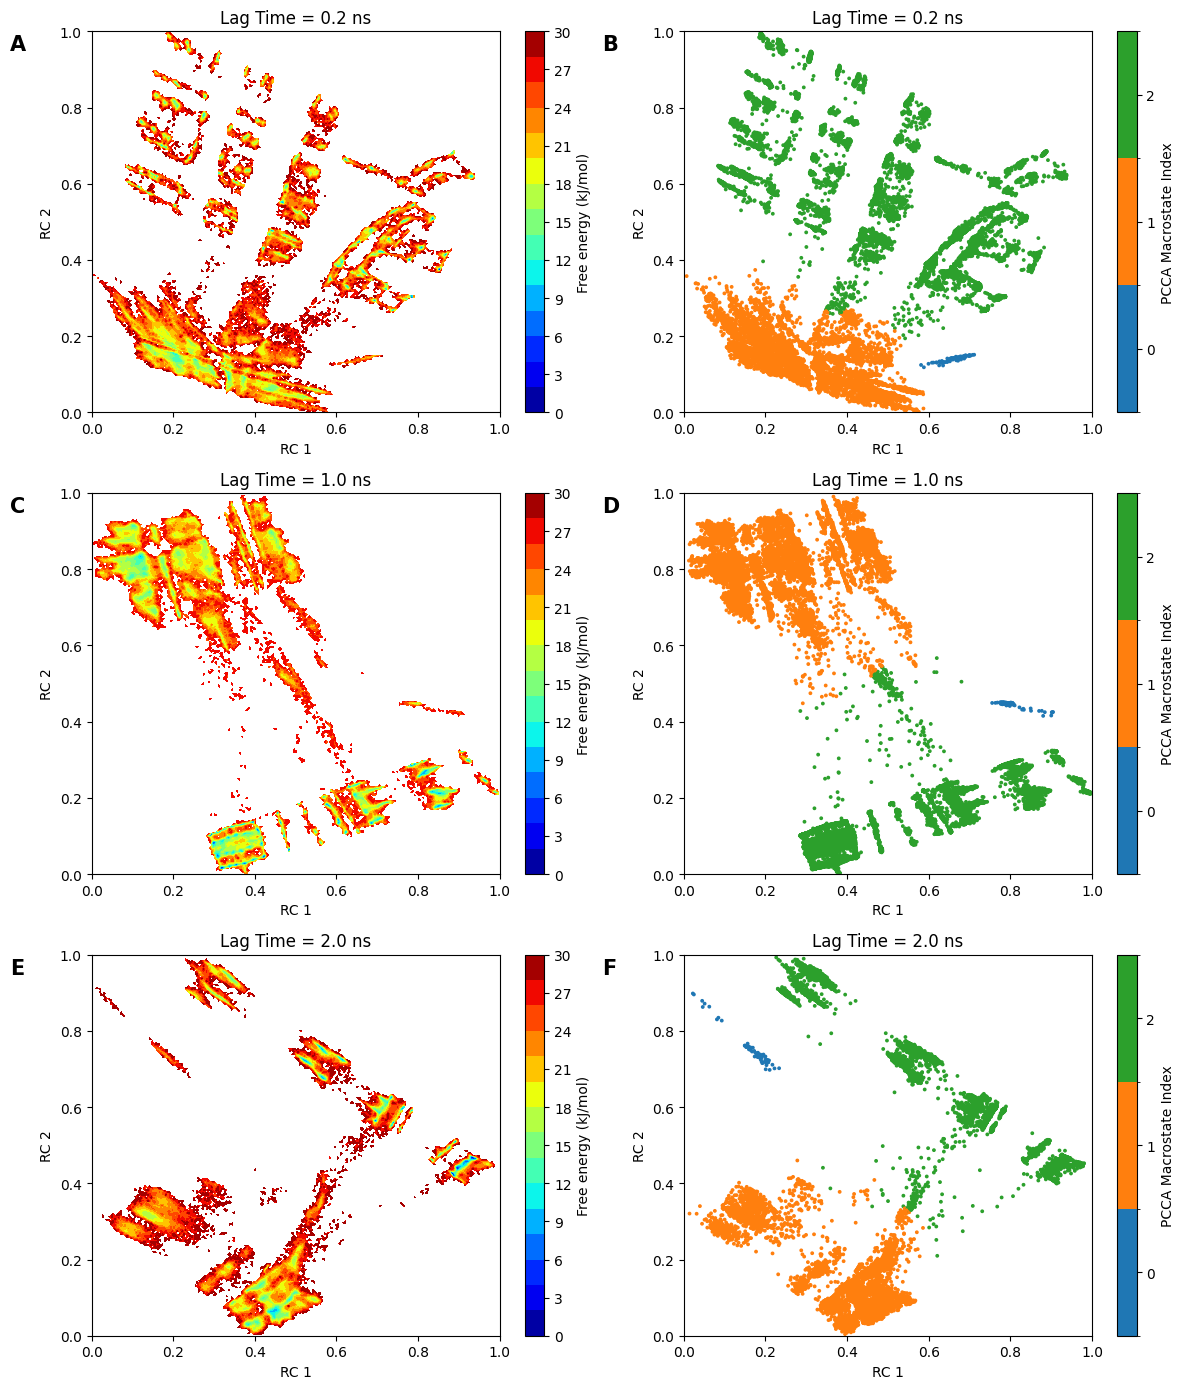

In [136]:
fig,ax = plt.subplots(nrows=3,ncols=2,figsize=(12,14))

rcflow_lagtimes=[1,5,10,25,50,100]

index_x = -0.2
index_y = 0.95

### lag=0.2ns
# 2D FES contour plot
vmax = 30
levels = np.linspace(0,vmax,16)
ticks = np.linspace(0,vmax,11)
contourf = ax[0,0].contourf(x_grid,y_grid,fes_2d[0].T,vmax=vmax,levels=levels,cmap='jet')
cb = fig.colorbar(contourf, ax=ax[0,0], label='Free energy (kJ/mol)',ticks=ticks)
ax[0,0].set_aspect('auto')
ax[0,0].set_xlabel('RC 1')
ax[0,0].set_ylabel('RC 2')
ax[0,0].set_xlim(0,1)
ax[0,0].set_ylim(0,1)
ax[0,0].set_title('Lag Time = {rcflow_lagtime} ns'.format(rcflow_lagtime=rcflow_lagtimes[0]*ns_per_step))


# PCCA assignments

cmap = matplotlib.colors.ListedColormap(plt.rcParams['axes.prop_cycle'].by_key()['color'][:n_metastable_sets])
norm = matplotlib.colors.BoundaryNorm(np.arange(-0.5,n_metastable_sets), cmap.N) 
sc = ax[0,1].scatter(normalized_r_all[0][:,0][::stride],normalized_r_all[0][:,1][::stride],c=macro_timeseries_all[0][::stride],cmap=cmap,norm=norm,s=markersize)
cb = fig.colorbar(sc,ticks=np.linspace(0,n_metastable_sets-1,n_metastable_sets),ax=ax[0,1],label='PCCA Macrostate Index')
ax[0,1].set_xlabel('RC 1')
ax[0,1].set_ylabel('RC 2')
ax[0,1].set_xlim(0,1)
ax[0,1].set_ylim(0,1)
ax[0,1].set_title('Lag Time = {rcflow_lagtime} ns'.format(rcflow_lagtime=rcflow_lagtimes[0]*ns_per_step))

### lag=1ns
# 2D FES contour plot
vmax = 30
levels = np.linspace(0,vmax,16)
ticks = np.linspace(0,vmax,11)
contourf = ax[1,0].contourf(x_grid,y_grid,fes_2d[1].T,vmax=vmax,levels=levels,cmap='jet')
cb = fig.colorbar(contourf, ax=ax[1,0], label='Free energy (kJ/mol)',ticks=ticks)
ax[1,0].set_aspect('auto')
ax[1,0].set_xlabel('RC 1')
ax[1,0].set_ylabel('RC 2')
ax[1,0].set_xlim(0,1)
ax[1,0].set_ylim(0,1)
ax[1,0].set_title('Lag Time = {rcflow_lagtime} ns'.format(rcflow_lagtime=rcflow_lagtimes[1]*ns_per_step))

# PCCA assignments

cmap = matplotlib.colors.ListedColormap(plt.rcParams['axes.prop_cycle'].by_key()['color'][:n_metastable_sets])
norm = matplotlib.colors.BoundaryNorm(np.arange(-0.5,n_metastable_sets), cmap.N) 
sc = ax[1,1].scatter(normalized_r_all[1][:,0][::stride],normalized_r_all[1][:,1][::stride],c=macro_timeseries_all[1][::stride],cmap=cmap,norm=norm,s=markersize)
cb = fig.colorbar(sc,ticks=np.linspace(0,n_metastable_sets-1,n_metastable_sets),ax=ax[1,1],label='PCCA Macrostate Index')
ax[1,1].set_xlabel('RC 1')
ax[1,1].set_ylabel('RC 2')
ax[1,1].set_xlim(0,1)
ax[1,1].set_ylim(0,1)
ax[1,1].set_title('Lag Time = {rcflow_lagtime} ns'.format(rcflow_lagtime=rcflow_lagtimes[1]*ns_per_step))


### lag=2ns
# 2D FES contour plot
vmax = 30
levels = np.linspace(0,vmax,16)
ticks = np.linspace(0,vmax,11)
contourf = ax[2,0].contourf(x_grid,y_grid,fes_2d[2].T,vmax=vmax,levels=levels,cmap='jet')
cb = fig.colorbar(contourf, ax=ax[2,0], label='Free energy (kJ/mol)',ticks=ticks)
ax[2,0].set_aspect('auto')
ax[2,0].set_xlabel('RC 1')
ax[2,0].set_ylabel('RC 2')
ax[2,0].set_xlim(0,1)
ax[2,0].set_ylim(0,1)
ax[2,0].set_title('Lag Time = {rcflow_lagtime} ns'.format(rcflow_lagtime=rcflow_lagtimes[2]*ns_per_step))

# PCCA assignments

cmap = matplotlib.colors.ListedColormap(plt.rcParams['axes.prop_cycle'].by_key()['color'][:n_metastable_sets])
norm = matplotlib.colors.BoundaryNorm(np.arange(-0.5,n_metastable_sets), cmap.N) 
sc = ax[2,1].scatter(normalized_r_all[2][:,0][::stride],normalized_r_all[2][:,1][::stride],c=macro_timeseries_all[2][::stride],cmap=cmap,norm=norm,s=markersize)
cb = fig.colorbar(sc,ticks=np.linspace(0,n_metastable_sets-1,n_metastable_sets),ax=ax[2,1],label='PCCA Macrostate Index')
ax[2,1].set_xlabel('RC 1')
ax[2,1].set_ylabel('RC 2')
ax[2,1].set_xlim(0,1)
ax[2,1].set_ylim(0,1)
ax[2,1].set_title('Lag Time = {rcflow_lagtime} ns'.format(rcflow_lagtime=rcflow_lagtimes[2]*ns_per_step))

ax[0,0].text(index_x, index_y, string.ascii_uppercase[0],transform=ax[0,0].transAxes, size=15, weight='bold')
ax[0,1].text(index_x, index_y, string.ascii_uppercase[1],transform=ax[0,1].transAxes, size=15, weight='bold')
ax[1,0].text(index_x, index_y, string.ascii_uppercase[2],transform=ax[1,0].transAxes, size=15, weight='bold')
ax[1,1].text(index_x, index_y, string.ascii_uppercase[3],transform=ax[1,1].transAxes, size=15, weight='bold')
ax[2,0].text(index_x, index_y, string.ascii_uppercase[4],transform=ax[2,0].transAxes, size=15, weight='bold')
ax[2,1].text(index_x, index_y, string.ascii_uppercase[5],transform=ax[2,1].transAxes, size=15, weight='bold')

plt.savefig('figures/fes_pcca/rcflow-lagtimes-fes_pcca-0.png',dpi=600)
plt.tight_layout()
plt.show()

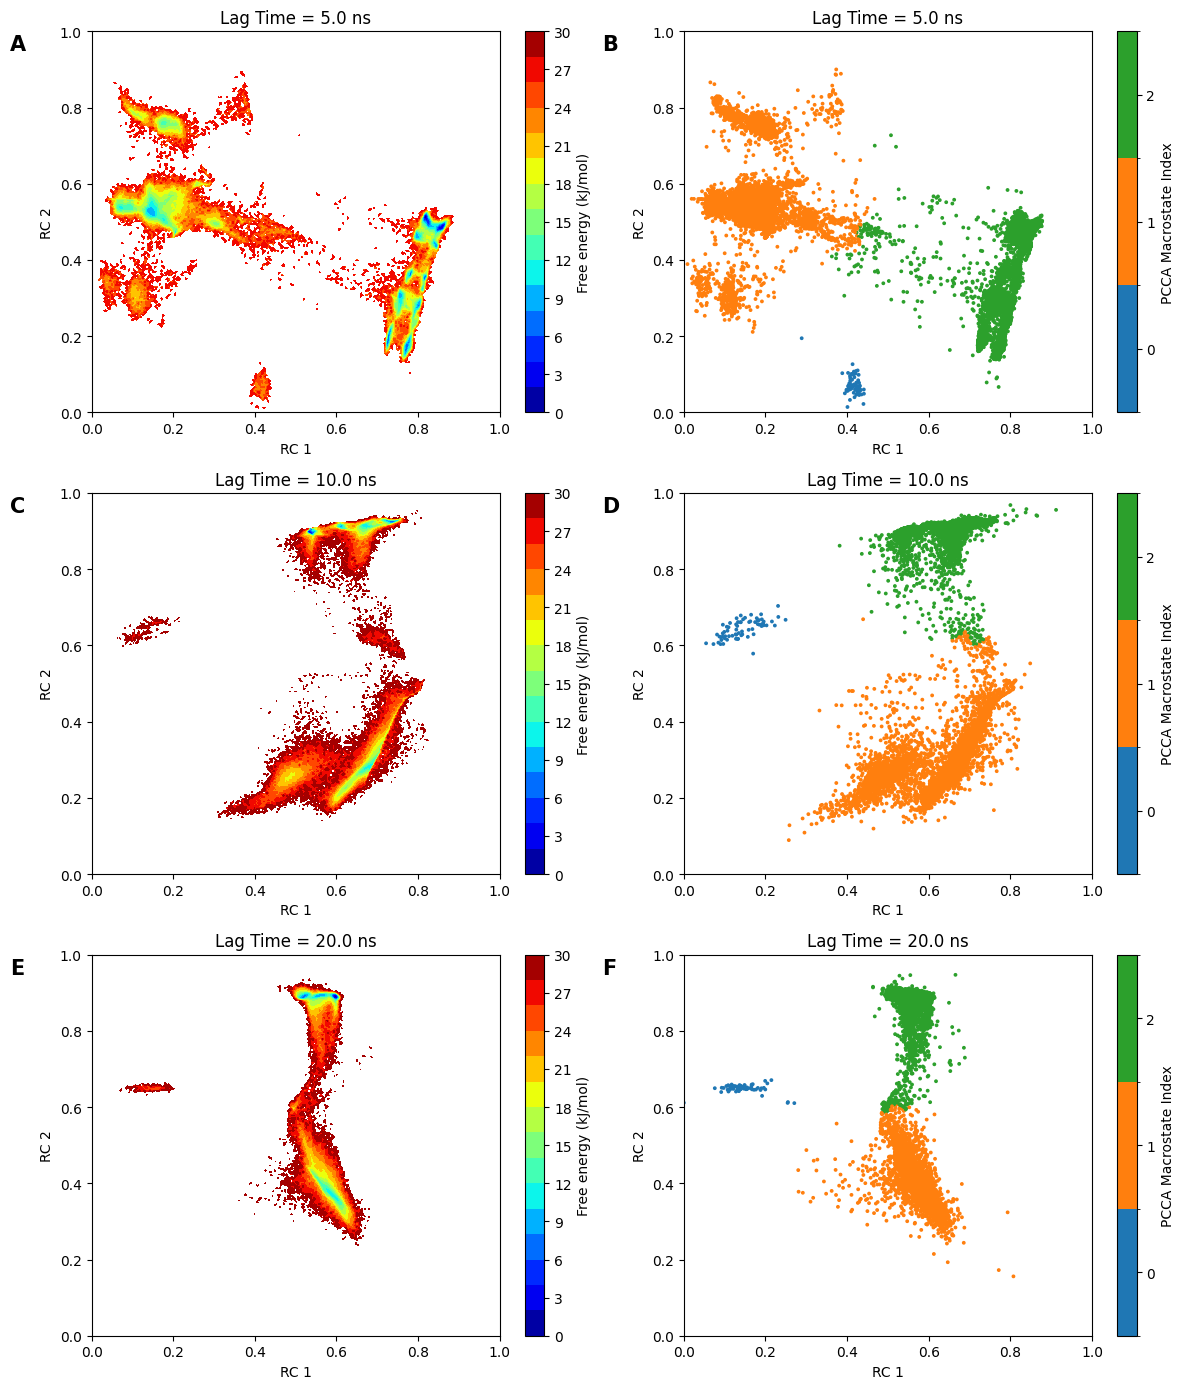

In [135]:
fig,ax = plt.subplots(nrows=3,ncols=2,figsize=(12,14))

rcflow_lagtimes=[1,5,10,25,50,100]

index_x = -0.2
index_y = 0.95

### lag=5ns
# 2D FES contour plot
vmax = 30
levels = np.linspace(0,vmax,16)
ticks = np.linspace(0,vmax,11)
contourf = ax[0,0].contourf(x_grid,y_grid,fes_2d[3].T,vmax=vmax,levels=levels,cmap='jet')
cb = fig.colorbar(contourf, ax=ax[0,0], label='Free energy (kJ/mol)',ticks=ticks)
ax[0,0].set_aspect('auto')
ax[0,0].set_xlabel('RC 1')
ax[0,0].set_ylabel('RC 2')
ax[0,0].set_xlim(0,1)
ax[0,0].set_ylim(0,1)
ax[0,0].set_title('Lag Time = {rcflow_lagtime} ns'.format(rcflow_lagtime=rcflow_lagtimes[3]*ns_per_step))


# PCCA assignments

cmap = matplotlib.colors.ListedColormap(plt.rcParams['axes.prop_cycle'].by_key()['color'][:n_metastable_sets])
norm = matplotlib.colors.BoundaryNorm(np.arange(-0.5,n_metastable_sets), cmap.N) 
sc = ax[0,1].scatter(normalized_r_all[3][:,0][::stride],normalized_r_all[3][:,1][::stride],c=macro_timeseries_all[3][::stride],cmap=cmap,norm=norm,s=markersize)
cb = fig.colorbar(sc,ticks=np.linspace(0,n_metastable_sets-1,n_metastable_sets),ax=ax[0,1],label='PCCA Macrostate Index')
ax[0,1].set_xlabel('RC 1')
ax[0,1].set_ylabel('RC 2')
ax[0,1].set_xlim(0,1)
ax[0,1].set_ylim(0,1)
ax[0,1].set_title('Lag Time = {rcflow_lagtime} ns'.format(rcflow_lagtime=rcflow_lagtimes[3]*ns_per_step))

### lag=10ns
# 2D FES contour plot
vmax = 30
levels = np.linspace(0,vmax,16)
ticks = np.linspace(0,vmax,11)
contourf = ax[1,0].contourf(x_grid,y_grid,fes_2d[4].T,vmax=vmax,levels=levels,cmap='jet')
cb = fig.colorbar(contourf, ax=ax[1,0], label='Free energy (kJ/mol)',ticks=ticks)
ax[1,0].set_aspect('auto')
ax[1,0].set_xlabel('RC 1')
ax[1,0].set_ylabel('RC 2')
ax[1,0].set_xlim(0,1)
ax[1,0].set_ylim(0,1)
ax[1,0].set_title('Lag Time = {rcflow_lagtime} ns'.format(rcflow_lagtime=rcflow_lagtimes[4]*ns_per_step))

# PCCA assignments

cmap = matplotlib.colors.ListedColormap(plt.rcParams['axes.prop_cycle'].by_key()['color'][:n_metastable_sets])
norm = matplotlib.colors.BoundaryNorm(np.arange(-0.5,n_metastable_sets), cmap.N) 
sc = ax[1,1].scatter(normalized_r_all[4][:,0][::stride],normalized_r_all[4][:,1][::stride],c=macro_timeseries_all[4][::stride],cmap=cmap,norm=norm,s=markersize)
cb = fig.colorbar(sc,ticks=np.linspace(0,n_metastable_sets-1,n_metastable_sets),ax=ax[1,1],label='PCCA Macrostate Index')
ax[1,1].set_xlabel('RC 1')
ax[1,1].set_ylabel('RC 2')
ax[1,1].set_xlim(0,1)
ax[1,1].set_ylim(0,1)
ax[1,1].set_title('Lag Time = {rcflow_lagtime} ns'.format(rcflow_lagtime=rcflow_lagtimes[4]*ns_per_step))


### lag=20ns
# 2D FES contour plot
vmax = 30
levels = np.linspace(0,vmax,16)
ticks = np.linspace(0,vmax,11)
contourf = ax[2,0].contourf(x_grid,y_grid,fes_2d[5].T,vmax=vmax,levels=levels,cmap='jet')
cb = fig.colorbar(contourf, ax=ax[2,0], label='Free energy (kJ/mol)',ticks=ticks)
ax[2,0].set_aspect('auto')
ax[2,0].set_xlabel('RC 1')
ax[2,0].set_ylabel('RC 2')
ax[2,0].set_xlim(0,1)
ax[2,0].set_ylim(0,1)
ax[2,0].set_title('Lag Time = {rcflow_lagtime} ns'.format(rcflow_lagtime=rcflow_lagtimes[5]*ns_per_step))

# PCCA assignments

cmap = matplotlib.colors.ListedColormap(plt.rcParams['axes.prop_cycle'].by_key()['color'][:n_metastable_sets])
norm = matplotlib.colors.BoundaryNorm(np.arange(-0.5,n_metastable_sets), cmap.N) 
sc = ax[2,1].scatter(normalized_r_all[5][:,0][::stride],normalized_r_all[5][:,1][::stride],c=macro_timeseries_all[5][::stride],cmap=cmap,norm=norm,s=markersize)
cb = fig.colorbar(sc,ticks=np.linspace(0,n_metastable_sets-1,n_metastable_sets),ax=ax[2,1],label='PCCA Macrostate Index')
ax[2,1].set_xlabel('RC 1')
ax[2,1].set_ylabel('RC 2')
ax[2,1].set_xlim(0,1)
ax[2,1].set_ylim(0,1)
ax[2,1].set_title('Lag Time = {rcflow_lagtime} ns'.format(rcflow_lagtime=rcflow_lagtimes[5]*ns_per_step))

ax[0,0].text(index_x, index_y, string.ascii_uppercase[0],transform=ax[0,0].transAxes, size=15, weight='bold')
ax[0,1].text(index_x, index_y, string.ascii_uppercase[1],transform=ax[0,1].transAxes, size=15, weight='bold')
ax[1,0].text(index_x, index_y, string.ascii_uppercase[2],transform=ax[1,0].transAxes, size=15, weight='bold')
ax[1,1].text(index_x, index_y, string.ascii_uppercase[3],transform=ax[1,1].transAxes, size=15, weight='bold')
ax[2,0].text(index_x, index_y, string.ascii_uppercase[4],transform=ax[2,0].transAxes, size=15, weight='bold')
ax[2,1].text(index_x, index_y, string.ascii_uppercase[5],transform=ax[2,1].transAxes, size=15, weight='bold')

plt.savefig('figures/fes_pcca/rcflow-lagtimes-fes_pcca-1.png',dpi=600)
plt.tight_layout()
plt.show()

#### 5. dim=2 TICA, SPIB and SRV

In [46]:
fes_2d = []
macro_timeseries_all = []
normalized_z_all = []

##### 5.1 SPIB

In [67]:
### SPIB
from spib.spib import SPIB
from spib.utils import prepare_data, DataNormalize

In [68]:
# Best
IB = torch.load('SPIB/spib_d=2_t=10_b=0.0010_learn=0.000030_final_SPIB1_ticadim30.model')
labels, prediction, z_latent, _ = IB.transform(traj_data, batch_size=batch_size, to_numpy=True)

### In general, we found that clustering in normalized latent space with a large n_microstates 
### is better than using the output state labels

# Calculate ITS and eigenvalues for MSM from SPIB output state labels
# assignments = labels
# Calculate ITS and eigenvalues for MSM from clustering in SPIB latent space
normalized_z = minmax_normalization(z_latent,axis=0)
assignments,cluster_centers = run_kmeans(normalized_z,n_microstates=n_microstates,n_jobs=n_jobs)

In [69]:
msm = build_MSM(msm_lagtime,assignments)

In [70]:
msm.eigenvalues()[1:3]

array([0.90297652, 0.42212671])

In [71]:
# Compute FES projected on 2D TICA space
unique_micro, count_micro = np.unique(assignments,return_counts=True)
assignments_weight = (msm.stationary_distribution / count_micro) / (msm.stationary_distribution / count_micro).sum()
assignments_weights = dict(enumerate(assignments_weight))
trajectory_weights = np.vectorize(assignments_weights.get)(assignments)

histogram_count, x_edge, y_edge = np.histogram2d(normalized_z[:,0],normalized_z[:,1],bins=(250,250),weights=trajectory_weights)
x_grid = 0.5 * (x_edge[:-1] + x_edge[1:])
y_grid = 0.5 * (y_edge[:-1] + y_edge[1:])

density = histogram_count / histogram_count.sum()
free_energy = -8.314*temperature/1000*np.log(density)
free_energy = free_energy-free_energy.min()

In [72]:
# PCCA
pcca = msm.pcca(n_metastable_sets=n_metastable_sets)

macro_assignments = dict(enumerate(pcca.assignments))
macro_timeseries = np.vectorize(macro_assignments.get)(assignments)

In [73]:
fes_2d.append(free_energy)
normalized_z_all.append(normalized_z)

In [74]:
# Worst
IB = torch.load('SPIB/spib_d=2_t=10_b=0.0010_learn=0.000030_final_SPIB3_ticadim30.model')
labels, prediction, z_latent, _ = IB.transform(traj_data, batch_size=batch_size, to_numpy=True)

### In general, we found that clustering in normalized latent space with a large n_microstates 
### is better than using the output state labels

# Calculate ITS and eigenvalues for MSM from SPIB output state labels
# assignments = labels
# Calculate ITS and eigenvalues for MSM from clustering in SPIB latent space
normalized_z = minmax_normalization(z_latent,axis=0)
assignments,cluster_centers = run_kmeans(normalized_z,n_microstates=n_microstates,n_jobs=n_jobs)

In [75]:
msm = build_MSM(msm_lagtime,assignments)
print(msm.eigenvalues()[1:4])

[0.90211485 0.08923753 0.06014797]


In [76]:
# Compute FES projected on 2D TICA space
unique_micro, count_micro = np.unique(assignments,return_counts=True)
assignments_weight = (msm.stationary_distribution / count_micro) / (msm.stationary_distribution / count_micro).sum()
assignments_weights = dict(enumerate(assignments_weight))
trajectory_weights = np.vectorize(assignments_weights.get)(assignments)

histogram_count, x_edge, y_edge = np.histogram2d(normalized_z[:,0],normalized_z[:,1],bins=(250,250),weights=trajectory_weights)
x_grid = 0.5 * (x_edge[:-1] + x_edge[1:])
y_grid = 0.5 * (y_edge[:-1] + y_edge[1:])

density = histogram_count / histogram_count.sum()
free_energy = -8.314*temperature/1000*np.log(density)
free_energy = free_energy-free_energy.min()

In [77]:
# PCCA
pcca = msm.pcca(n_metastable_sets=n_metastable_sets)

macro_assignments = dict(enumerate(pcca.assignments))
macro_timeseries = np.vectorize(macro_assignments.get)(assignments)

In [78]:
fes_2d.append(free_energy)
normalized_z_all.append(normalized_z)

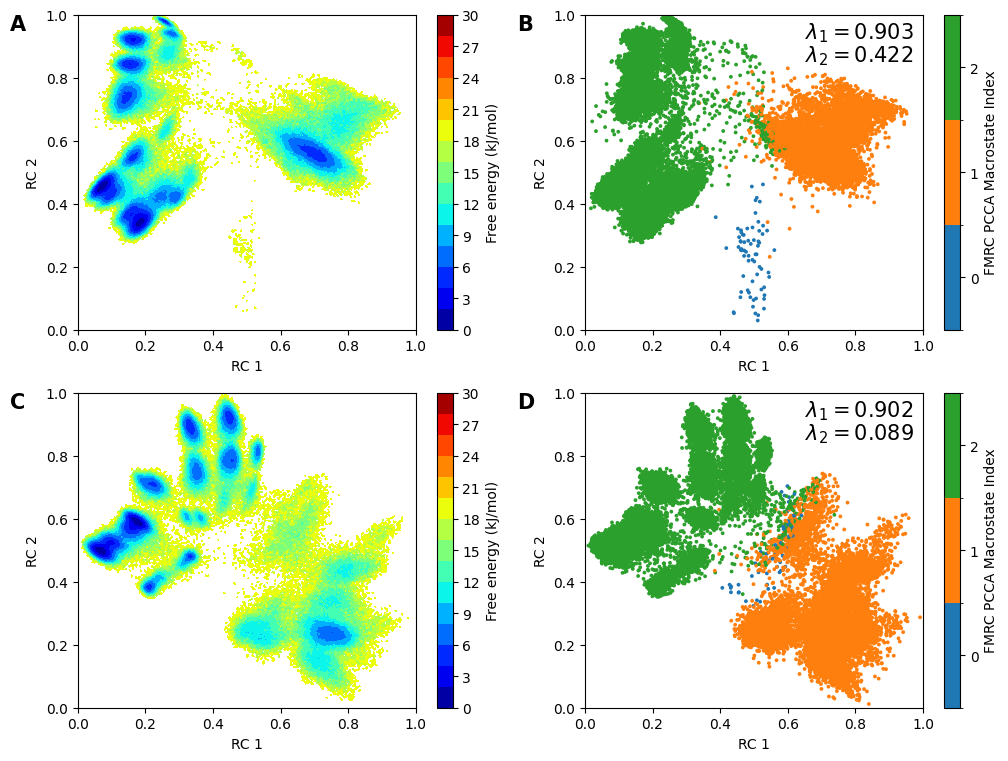

In [80]:
fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(12,9))

index_x = -0.2
index_y = 0.95

# 2D FES contour plot
vmax = 30
levels = np.linspace(0,vmax,16)
ticks = np.linspace(0,vmax,11)
contourf = ax[0,0].contourf(x_grid,y_grid,fes_2d[0].T,vmax=vmax,levels=levels,cmap='jet')
cb = fig.colorbar(contourf, ax=ax[0,0], label='Free energy (kJ/mol)',ticks=ticks)
ax[0,0].set_aspect('auto')
ax[0,0].set_xlabel('RC 1')
ax[0,0].set_ylabel('RC 2')
ax[0,0].set_xlim(0,1)
ax[0,0].set_ylim(0,1)

# PCCA assignments

cmap = matplotlib.colors.ListedColormap(plt.rcParams['axes.prop_cycle'].by_key()['color'][:n_metastable_sets])
norm = matplotlib.colors.BoundaryNorm(np.arange(-0.5,n_metastable_sets), cmap.N) 
sc = ax[0,1].scatter(normalized_z_all[0][:,0][::stride],normalized_z_all[0][:,1][::stride],c=macro_rcflow[::stride],cmap=cmap,norm=norm,s=markersize)
cb = fig.colorbar(sc,ticks=np.linspace(0,n_metastable_sets-1,n_metastable_sets),ax=ax[0,1],label='FMRC PCCA Macrostate Index')
ax[0,1].set_xlabel('RC 1')
ax[0,1].set_ylabel('RC 2')
ax[0,1].set_xlim(0,1)
ax[0,1].set_ylim(0,1)

# 2D FES contour plot
vmax = 30
levels = np.linspace(0,vmax,16)
ticks = np.linspace(0,vmax,11)
contourf = ax[1,0].contourf(x_grid,y_grid,fes_2d[1].T,vmax=vmax,levels=levels,cmap='jet')
cb = fig.colorbar(contourf, ax=ax[1,0], label='Free energy (kJ/mol)',ticks=ticks)
ax[1,0].set_aspect('auto')
ax[1,0].set_xlabel('RC 1')
ax[1,0].set_ylabel('RC 2')
ax[1,0].set_xlim(0,1)
ax[1,0].set_ylim(0,1)

# PCCA assignments

cmap = matplotlib.colors.ListedColormap(plt.rcParams['axes.prop_cycle'].by_key()['color'][:n_metastable_sets])
norm = matplotlib.colors.BoundaryNorm(np.arange(-0.5,n_metastable_sets), cmap.N) 
sc = ax[1,1].scatter(normalized_z_all[1][:,0][::stride],normalized_z_all[1][:,1][::stride],c=macro_rcflow[::stride],cmap=cmap,norm=norm,s=markersize)
cb = fig.colorbar(sc,ticks=np.linspace(0,n_metastable_sets-1,n_metastable_sets),ax=ax[1,1],label='FMRC PCCA Macrostate Index')
ax[1,1].set_xlabel('RC 1')
ax[1,1].set_ylabel('RC 2')
ax[1,1].set_xlim(0,1)
ax[1,1].set_ylim(0,1)

ax[0,0].text(index_x, index_y, string.ascii_uppercase[0],transform=ax[0,0].transAxes, size=15, weight='bold')
ax[0,1].text(index_x, index_y, string.ascii_uppercase[1],transform=ax[0,1].transAxes, size=15, weight='bold')
ax[1,0].text(index_x, index_y, string.ascii_uppercase[2],transform=ax[1,0].transAxes, size=15, weight='bold')
ax[1,1].text(index_x, index_y, string.ascii_uppercase[3],transform=ax[1,1].transAxes, size=15, weight='bold')

ax[0,1].text(0.65, 0.925, r'$\lambda_1 = 0.903$',transform=ax[0,1].transAxes, size=15)
ax[0,1].text(0.65, 0.85, r'$\lambda_2 = 0.422$',transform=ax[0,1].transAxes, size=15)

ax[1,1].text(0.65, 0.925, r'$\lambda_1 = 0.902$',transform=ax[1,1].transAxes, size=15)
ax[1,1].text(0.65, 0.85, r'$\lambda_2 = 0.089$',transform=ax[1,1].transAxes, size=15)
plt.savefig('figures/fes_pcca/SPIB-lag10.png',dpi=600)
plt.show()

In [81]:
fes_2d.append(free_energy)
macro_timeseries_all.append(macro_timeseries)
fes_grid_x_spib = x_grid
fes_grid_y_spib = y_grid

##### 5.2 SRV

In [82]:
fes_2d = []
macro_timeseries_all = []
srv_output_all = []
x_grid_all = []
y_grid_all = []

In [83]:
# Best
srv = load_snrv('models/srv-lag10-sincos-100hidden-final-100epoch-1.pt')

In [84]:
dataset = torch.tensor(data[0],dtype=torch.float32)

In [85]:
# Transform into RC space
no_iteration = traj_data.shape[0]//batchsize_transform + 1

# Transforming the whole dataset at once might exceed CUDA memory capacity.
# We can transform a small amount of samples every transformation and then concats all transformed data, similar to minibatch training

srv_output = []
for i in range(no_iteration):
    srv_output_i = srv.transform(dataset[i*batchsize_transform:(i+1)*batchsize_transform]).cpu().detach().numpy()
    srv_output.append(srv_output_i)
srv_output = np.concatenate(srv_output)

# kmeans
assignments,cluster_centers = run_kmeans(srv_output[:,1:],n_microstates=n_microstates,n_jobs=n_jobs)

In [86]:
msm = build_MSM(msm_lagtime,assignments)
print(msm.eigenvalues()[1:4])

[ 0.90379154  0.38628331 -0.13381914]


In [87]:
# Compute FES projected on 2D TICA space
unique_micro, count_micro = np.unique(assignments,return_counts=True)
assignments_weight = (msm.stationary_distribution / count_micro) / (msm.stationary_distribution / count_micro).sum()
assignments_weights = dict(enumerate(assignments_weight))
trajectory_weights = np.vectorize(assignments_weights.get)(assignments)

histogram_count, x_edge, y_edge = np.histogram2d(srv_output[:,1],srv_output[:,2],bins=(250,250),weights=trajectory_weights)
x_grid = 0.5 * (x_edge[:-1] + x_edge[1:])
y_grid = 0.5 * (y_edge[:-1] + y_edge[1:])

density = histogram_count / histogram_count.sum()
free_energy = -8.314*temperature/1000*np.log(density)
free_energy = free_energy-free_energy.min()

In [88]:
# PCCA
pcca = msm.pcca(n_metastable_sets=n_metastable_sets)

macro_assignments = dict(enumerate(pcca.assignments))
macro_timeseries = np.vectorize(macro_assignments.get)(assignments)

In [89]:
fes_2d.append(free_energy)
srv_output_all.append(srv_output)
x_grid_all.append(x_grid)
y_grid_all.append(y_grid)

In [90]:
# Worst
srv = load_snrv('models/srv-lag10-sincos-100hidden-final-100epoch-4.pt')

In [91]:
# Transform into RC space
no_iteration = traj_data.shape[0]//batchsize_transform + 1

# Transforming the whole dataset at once might exceed CUDA memory capacity.
# We can transform a small amount of samples every transformation and then concats all transformed data, similar to minibatch training

srv_output = []
for i in range(no_iteration):
    srv_output_i = srv.transform(dataset[i*batchsize_transform:(i+1)*batchsize_transform]).cpu().detach().numpy()
    srv_output.append(srv_output_i)
srv_output = np.concatenate(srv_output)

# kmeans
assignments,cluster_centers = run_kmeans(srv_output[:,1:],n_microstates=n_microstates,n_jobs=n_jobs)

In [92]:
msm = build_MSM(msm_lagtime,assignments)
print(msm.eigenvalues()[1:4])

[ 0.90329408  0.17969154 -0.09315562]


In [93]:
# Compute FES projected on 2D TICA space
unique_micro, count_micro = np.unique(assignments,return_counts=True)
assignments_weight = (msm.stationary_distribution / count_micro) / (msm.stationary_distribution / count_micro).sum()
assignments_weights = dict(enumerate(assignments_weight))
trajectory_weights = np.vectorize(assignments_weights.get)(assignments)

histogram_count, x_edge, y_edge = np.histogram2d(srv_output[:,1],srv_output[:,2],bins=(250,250),weights=trajectory_weights)
x_grid = 0.5 * (x_edge[:-1] + x_edge[1:])
y_grid = 0.5 * (y_edge[:-1] + y_edge[1:])

density = histogram_count / histogram_count.sum()
free_energy = -8.314*temperature/1000*np.log(density)
free_energy = free_energy-free_energy.min()

In [94]:
# PCCA
pcca = msm.pcca(n_metastable_sets=n_metastable_sets)

macro_assignments = dict(enumerate(pcca.assignments))
macro_timeseries = np.vectorize(macro_assignments.get)(assignments)

In [95]:
fes_2d.append(free_energy)
srv_output_all.append(srv_output)
x_grid_all.append(x_grid)
y_grid_all.append(y_grid)

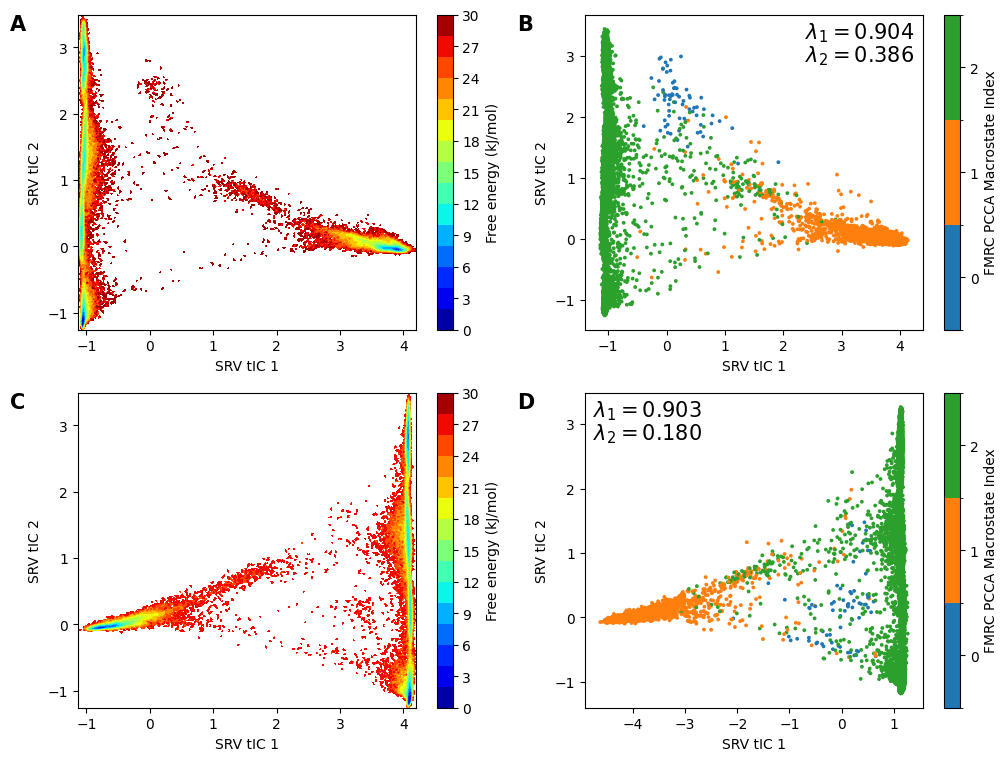

In [97]:
fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(12,9))

index_x = -0.2
index_y = 0.95

# 2D FES contour plot
vmax = 30
levels = np.linspace(0,vmax,16)
ticks = np.linspace(0,vmax,11)
contourf = ax[0,0].contourf(x_grid_all[0],y_grid_all[0],fes_2d[0].T,vmax=vmax,levels=levels,cmap='jet')
cb = fig.colorbar(contourf, ax=ax[0,0], label='Free energy (kJ/mol)',ticks=ticks)
ax[0,0].set_aspect('auto')
ax[0,0].set_xlabel('SRV tIC 1')
ax[0,0].set_ylabel('SRV tIC 2')

# PCCA assignments

cmap = matplotlib.colors.ListedColormap(plt.rcParams['axes.prop_cycle'].by_key()['color'][:n_metastable_sets])
norm = matplotlib.colors.BoundaryNorm(np.arange(-0.5,n_metastable_sets), cmap.N) 
sc = ax[0,1].scatter(srv_output_all[0][:,1][::stride],srv_output_all[0][:,2][::stride],c=macro_rcflow[::stride],cmap=cmap,norm=norm,s=markersize)
cb = fig.colorbar(sc,ticks=np.linspace(0,n_metastable_sets-1,n_metastable_sets),ax=ax[0,1],label='FMRC PCCA Macrostate Index')
ax[0,1].set_xlabel('SRV tIC 1')
ax[0,1].set_ylabel('SRV tIC 2')


# 2D FES contour plot
vmax = 30
levels = np.linspace(0,vmax,16)
ticks = np.linspace(0,vmax,11)
contourf = ax[1,0].contourf(x_grid_all[0],y_grid_all[0],fes_2d[1].T,vmax=vmax,levels=levels,cmap='jet')
cb = fig.colorbar(contourf, ax=ax[1,0], label='Free energy (kJ/mol)',ticks=ticks)
ax[1,0].set_aspect('auto')
ax[1,0].set_xlabel('SRV tIC 1')
ax[1,0].set_ylabel('SRV tIC 2')


# PCCA assignments

cmap = matplotlib.colors.ListedColormap(plt.rcParams['axes.prop_cycle'].by_key()['color'][:n_metastable_sets])
norm = matplotlib.colors.BoundaryNorm(np.arange(-0.5,n_metastable_sets), cmap.N) 
sc = ax[1,1].scatter(srv_output_all[1][:,1][::stride],srv_output_all[1][:,2][::stride],c=macro_rcflow[::stride],cmap=cmap,norm=norm,s=markersize)
cb = fig.colorbar(sc,ticks=np.linspace(0,n_metastable_sets-1,n_metastable_sets),ax=ax[1,1],label='FMRC PCCA Macrostate Index')
ax[1,1].set_xlabel('SRV tIC 1')
ax[1,1].set_ylabel('SRV tIC 2')

ax[0,0].text(index_x, index_y, string.ascii_uppercase[0],transform=ax[0,0].transAxes, size=15, weight='bold')
ax[0,1].text(index_x, index_y, string.ascii_uppercase[1],transform=ax[0,1].transAxes, size=15, weight='bold')
ax[1,0].text(index_x, index_y, string.ascii_uppercase[2],transform=ax[1,0].transAxes, size=15, weight='bold')
ax[1,1].text(index_x, index_y, string.ascii_uppercase[3],transform=ax[1,1].transAxes, size=15, weight='bold')

ax[0,1].text(0.65, 0.925, r'$\lambda_1 = 0.904$',transform=ax[0,1].transAxes, size=15)
ax[0,1].text(0.65, 0.85, r'$\lambda_2 = 0.386$',transform=ax[0,1].transAxes, size=15)

ax[1,1].text(0.025, 0.925, r'$\lambda_1 = 0.903$',transform=ax[1,1].transAxes, size=15)
ax[1,1].text(0.025, 0.85, r'$\lambda_2 = 0.180$',transform=ax[1,1].transAxes, size=15)
plt.savefig('figures/fes_pcca/srv-lag10.png',dpi=600)
plt.show()

In [218]:
fes_2d.append(free_energy)
macro_timeseries_all.append(macro_timeseries)
fes_grid_x_srv = x_grid
fes_grid_y_srv = y_grid

##### 5.3 TICA dim=2

In [98]:
#### Hyperparameters
dim = 2
tica_lagtime = 10
var_cutoff = None
koopman = False

# TICA & k-means
tica,tica_output = run_TICA(data_tica,lagtime=tica_lagtime,dim=dim,var_cutoff=var_cutoff,koopman=koopman)
assignments,cluster_centers = run_kmeans(tica_output,n_microstates=n_microstates,n_jobs=n_jobs)

In [99]:
msm = build_MSM(msm_lagtime,assignments)
print(msm.eigenvalues()[1:4])

[0.90255386 0.11650416 0.05840357]


In [100]:
# Compute FES projected on 2D TICA space
unique_micro, count_micro = np.unique(assignments,return_counts=True)
assignments_weight = (msm.stationary_distribution / count_micro) / (msm.stationary_distribution / count_micro).sum()
assignments_weights = dict(enumerate(assignments_weight))
trajectory_weights = np.vectorize(assignments_weights.get)(assignments)

histogram_count, x_edge, y_edge = np.histogram2d(tica_output[:,0],tica_output[:,1],bins=(250,250),weights=trajectory_weights)
x_grid = 0.5 * (x_edge[:-1] + x_edge[1:])
y_grid = 0.5 * (y_edge[:-1] + y_edge[1:])

density = histogram_count / histogram_count.sum()
free_energy = -8.314*temperature/1000*np.log(density)
free_energy = free_energy-free_energy.min()

In [101]:
# PCCA
pcca = msm.pcca(n_metastable_sets=n_metastable_sets)

macro_assignments = dict(enumerate(pcca.assignments))
macro_timeseries = np.vectorize(macro_assignments.get)(assignments)

In [232]:
# Match previous state labels
#macro_timeseries[macro_timeseries == 1] = 3
#macro_timeseries[macro_timeseries == 2] = 1
#macro_timeseries[macro_timeseries == 3] = 2

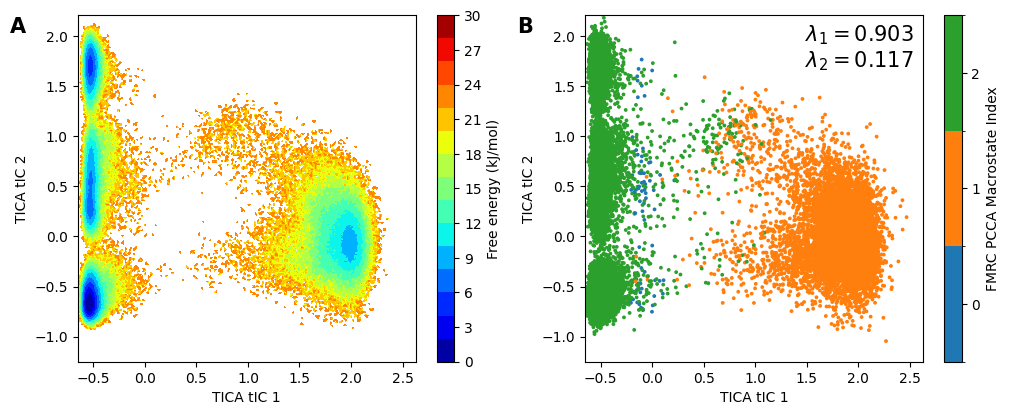

In [103]:
stride = 10
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(12,4.5))

index_x = -0.2
index_y = 0.95

# 2D FES contour plot
vmax = 30
levels = np.linspace(0,vmax,16)
ticks = np.linspace(0,vmax,11)
contourf = ax[0].contourf(x_grid,y_grid,free_energy.T,vmax=vmax,levels=levels,cmap='jet')
cb = fig.colorbar(contourf, ax=ax[0], label='Free energy (kJ/mol)',ticks=ticks)
ax[0].set_aspect('auto')
ax[0].set_xlabel('TICA tIC 1')
ax[0].set_ylabel('TICA tIC 2')

# PCCA assignments

cmap = matplotlib.colors.ListedColormap(plt.rcParams['axes.prop_cycle'].by_key()['color'][:n_metastable_sets])
norm = matplotlib.colors.BoundaryNorm(np.arange(-0.5,n_metastable_sets), cmap.N) 
sc = ax[1].scatter(tica_output[:,0][::stride],tica_output[:,1][::stride],c=macro_rcflow[::stride],cmap=cmap,norm=norm,s=markersize)
cb = fig.colorbar(sc,ticks=np.linspace(0,n_metastable_sets-1,n_metastable_sets),ax=ax[1],label='FMRC PCCA Macrostate Index')
ax[1].set_xlabel('TICA tIC 1')
ax[1].set_ylabel('TICA tIC 2')
ax[1].set_xlim(x_grid.min(),x_grid.max())
ax[1].set_ylim(y_grid.min(),y_grid.max())

ax[0].text(index_x, index_y, string.ascii_uppercase[0],transform=ax[0].transAxes, size=15, weight='bold')
ax[1].text(index_x, index_y, string.ascii_uppercase[1],transform=ax[1].transAxes, size=15, weight='bold')

ax[1].text(0.65, 0.925, r'$\lambda_1 = 0.903$',transform=ax[1].transAxes, size=15)
ax[1].text(0.65, 0.85, r'$\lambda_2 = 0.117$',transform=ax[1].transAxes, size=15)

plt.savefig('figures/fes_pcca/tica-lag10.png',dpi=600)
plt.show()